In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

balls_threshold = 50 #Change this number to change the minimum number of balls faced by a batsman

path = "/Users/samarth/Desktop/Plaksha/Dream 11 team prediction/IPL_Ball_by_Ball_2008_2022.csv"
df = pd.read_csv(path)

path = "/Users/samarth/Desktop/Plaksha/Dream 11 team prediction/IPL_Matches_2008_2022.csv"
df2 = pd.read_csv(path)

#Delhi Daredevils has been rebranded to Delhi Capitals, therefore both Delhi Daredevils and Delhi Capitals are saved as Delhi
#Rising Pune Supergiants had a typo in some of the columns and it was written as Rising Pune Supergiant. That has also been fixed

df2 = df2.replace({"Team1": {"Delhi Daredevils": "Delhi", "Delhi Capitals": "Delhi", "Rising Pune Supergiant": "Rising Pune Supergiants","Royal Challengers Bangalore":"Royal Challengers Bengaluru"},
                            "Team2": {"Delhi Daredevils": "Delhi", "Delhi Capitals": "Delhi", "Rising Pune Supergiant": "Rising Pune Supergiants","Royal Challengers Bangalore":"Royal Challengers Bengaluru"},
                            "WinningTeam": {"Delhi Daredevils": "Delhi", "Delhi Capitals": "Delhi", "Rising Pune Supergiant": "Rising Pune Supergiants","Royal Challengers Bangalore":"Royal Challengers Bengaluru"}})

df = df.replace({"BattingTeam": {"Delhi Daredevils": "Delhi", "Delhi Capitals": "Delhi", "Rising Pune Supergiant": "Rising Pune Supergiants"}})

#Dropping all rain affected matches or abandoned matches

counter = 0
indices = []
for i in df2['ID']:
    row = df2.loc[df2['ID'] == i].iloc[0]
    if pd.notna(row['method']) or row['WonBy'] == 'NoResults':
        counter += 1
        indices.append(i)


for i in indices:
    df = df[df['ID'] != i]
    df2 = df2[df2['ID'] != i]

ball_by_ball_df = df
matches_df = df2

bowlers = ball_by_ball_df['bowler'].unique()
bowling_averages_dict = {}

for bowler in bowlers:
    bowler_bowling = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]
    
    total_balls_bowled = len(bowler_bowling)
    
    total_runs_conceded = bowler_bowling['total_run'].sum()
    
    # Count the number of wickets taken by the bowler (excluding run outs, wickets taken on no balls, and wickets taken on free hits)
    wickets_mask = (bowler_bowling['player_out'].notna()) & (bowler_bowling['kind'] != 'run out') & (bowler_bowling['extra_type'] != 'noballs')
    freehit_mask = bowler_bowling['extra_type'].shift(1) == 'noballs'
    total_wickets = np.sum(wickets_mask & ~freehit_mask)
    
    #threshold is set at 200 minimum number of balls bowled
    if total_balls_bowled >= balls_threshold:
        # for bowling average
        if total_wickets > 0:
            bowling_average = total_runs_conceded / total_wickets
            bowling_averages_dict[bowler] = bowling_average

sorted_bowling_averages = sorted(bowling_averages_dict.items(), key=lambda x: x[1])
print("Bowling averages of bowlers who have bowled a minimum of 200 balls (in ascending order, excluding run outs, wickets taken on no balls, and wickets taken on free hits):")


sorted_bowling_averages = dict(sorted_bowling_averages)
bowling_averages_df = pd.DataFrame.from_dict(sorted_bowling_averages , orient='index', columns=['Average'])
bowling_averages_df['Average'] = (bowling_averages_df['Average'] - bowling_averages_df['Average'].mean()) * -1 / bowling_averages_df['Average'].std()


matches_df = df2
batsmen = ball_by_ball_df['batter'].unique()
averages_dict = {}

for batsman in batsmen:
    batsman_batting = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
    
    total_balls_faced = len(batsman_batting)
    
    # threshold at minimum 200 balls faced
    if total_balls_faced >= balls_threshold:
        match_stats = batsman_batting.groupby('ID').agg({'batsman_run': 'sum'}).reset_index()

        total_runs = match_stats['batsman_run'].sum()
        total_innings = len(match_stats)
        
        #number of dismissals for the batsman
        total_dismissals = np.sum(ball_by_ball_df['player_out'] == batsman)
        if total_dismissals > 0:
            overall_average = total_runs / total_dismissals
            averages_dict[batsman] = overall_average


batsmen_averages_df = pd.DataFrame.from_dict(averages_dict, orient='index', columns=['Average'])
batsmen_averages_df['Standardized Average'] = (batsmen_averages_df['Average'] - batsmen_averages_df['Average'].mean()) / batsmen_averages_df['Average'].std()

batsmen_averages_df = batsmen_averages_df.sort_values(by='Average', ascending=False)
print("Batting Averages and Standardized Averages for batsmen who have faced at least 200 balls:")


ball_by_ball_df = df
matches_df = df2

batsmen = ball_by_ball_df['batter'].unique()
strike_rates_dict = {}

for batsman in batsmen:
    batsman_batting = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
    
    # Count the total number of balls faced by the batsman (excluding wide and no balls)
    balls_faced = len(batsman_batting[(batsman_batting['extras_run'] == 0) | ((batsman_batting['extra_type'] != 'wides') & (batsman_batting['extra_type'] != 'noballs'))])
 
    if balls_faced >= balls_threshold:
        runs_scored = batsman_batting[batsman_batting['extra_type'] != 'legbyes']['batsman_run'].sum()
        strike_rate = (runs_scored * 100) / balls_faced
        strike_rates_dict[batsman] = strike_rate

strike_rates_df = pd.DataFrame.from_dict(strike_rates_dict, orient='index', columns=['Strike Rate'])
strike_rates_df = strike_rates_df.sort_values(by='Strike Rate', ascending=False)
print("Strike Rates (minimum 200 balls faced, excluding leg byes, wide, and no balls):")

strike_rates_df['Standardised'] = (strike_rates_df['Strike Rate'] - strike_rates_df['Strike Rate'].mean())/ strike_rates_df['Strike Rate'].std()





ball_by_ball_df = df
matches_df = df2


bowlers = ball_by_ball_df['bowler'].unique()
balls_per_wicket_dict = {}

for bowler in bowlers:
    bowler_bowling = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]

    total_balls_bowled = len(bowler_bowling)

    if total_balls_bowled >= balls_threshold:
        wickets_mask = (bowler_bowling['player_out'].notna()) & (bowler_bowling['kind'] != 'run out') & (bowler_bowling['extra_type'] != 'noballs')

        freehit_mask = bowler_bowling['extra_type'].shift(1) == 'noballs'

        total_wickets = wickets_mask[~freehit_mask].sum()
        if total_wickets > 0:
            balls_per_wicket = total_balls_bowled / total_wickets
            balls_per_wicket_dict[bowler] = balls_per_wicket

balls_per_wicket_df = pd.DataFrame.from_dict(balls_per_wicket_dict, orient='index', columns=['Balls per Wicket'])

balls_per_wicket_df = balls_per_wicket_df.sort_values(by='Balls per Wicket')

print("Balls per Wicket (minimum 200 balls bowled):")


balls_per_wicket_df['Standardised'] = (balls_per_wicket_df['Balls per Wicket'] - balls_per_wicket_df['Balls per Wicket'].mean()) * -1 / balls_per_wicket_df['Balls per Wicket'].std()

ball_by_ball_df = df
matches_df = df2

batsmen = ball_by_ball_df['batter'].unique()

avg_balls_faced_dict = {}

for batsman in batsmen:
    batsman_batting = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]

    innings_played = batsman_batting['ID'].nunique()

    balls_faced = len(batsman_batting[(batsman_batting['extras_run'] == 0) | ((batsman_batting['extra_type'] != 'wides') & (batsman_batting['extra_type'] != 'noballs'))])

    if balls_faced >= balls_threshold:
        avg_balls_faced = balls_faced / innings_played
        avg_balls_faced_dict[batsman] = avg_balls_faced

avg_balls_faced_df = pd.DataFrame.from_dict(avg_balls_faced_dict, orient='index', columns=['Average Balls Faced'])

avg_balls_faced_df = avg_balls_faced_df.sort_values(by='Average Balls Faced', ascending=False)

print("Average Balls Faced (minimum 200 balls faced, excluding wide and no balls):")

avg_balls_faced_df['Standardised'] = (avg_balls_faced_df['Average Balls Faced'] - avg_balls_faced_df['Average Balls Faced'].mean())/ avg_balls_faced_df['Average Balls Faced'].std()

ball_by_ball_df = df
matches_df = df2
batsmen = ball_by_ball_df['batter'].unique()

centuries_dict = {}
for batsman in batsmen:
    batsman_batting = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
    match_runs = batsman_batting.groupby('ID')['batsman_run'].sum()
    centuries = len(match_runs[match_runs >= 100])
    
    if centuries > 0:
        centuries_dict[batsman] = centuries

centuries_df = pd.DataFrame.from_dict(centuries_dict, orient='index', columns=['centuries'])
centuries_df = centuries_df.sort_values(by='centuries', ascending=False)

print("Number of Centuries for each batsman:")
centuries_df['Standardised'] = (centuries_df ['centuries'] - centuries_df['centuries'].mean())/ centuries_df['centuries'].std()

ball_by_ball_df = df
matches_df = df2

batsmen = ball_by_ball_df['batter'].unique()
half_centuries_dict = {}

for batsman in batsmen:
    batsman_batting = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
    match_runs = batsman_batting.groupby('ID')['batsman_run'].sum()
    half_centuries = len(match_runs[(match_runs >= 50) & (match_runs < 100)])
    if half_centuries >= 1:
        half_centuries_dict[batsman] = half_centuries

half_centuries_df = pd.DataFrame.from_dict(half_centuries_dict, orient='index', columns=['Half-Centuries'])
half_centuries_df = half_centuries_df.sort_values(by='Half-Centuries', ascending=False)
print("Number of Half-Centuries for batsmen with a minimum of 1 half-century:")

half_centuries_df['Standardised'] = (half_centuries_df['Half-Centuries'] - half_centuries_df['Half-Centuries'].mean())/ half_centuries_df['Half-Centuries'].std()

ball_by_ball_df = df
matches_df = df2

batsmen = ball_by_ball_df['batter'].unique()
fours_per_innings_dict = {}

for batsman in batsmen:
    batsman_batting = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
    balls_faced = len(batsman_batting)

    if balls_faced >= balls_threshold:
        innings_played = batsman_batting['ID'].nunique()
    
        total_fours = batsman_batting[batsman_batting['batsman_run'] == 4].shape[0]
        fours_per_innings = total_fours / innings_played
        fours_per_innings_dict[batsman] = fours_per_innings

fours_per_innings_df = pd.DataFrame.from_dict(fours_per_innings_dict, orient='index', columns=['4s per Innings'])
fours_per_innings_df = fours_per_innings_df.sort_values(by='4s per Innings', ascending=False)

print("Average number of 4's per innings for batsmen:")

fours_per_innings_df['Standardised'] = (fours_per_innings_df['4s per Innings'] - fours_per_innings_df['4s per Innings'].mean())/ fours_per_innings_df['4s per Innings'].std()

matches_df = df2

batsmen = ball_by_ball_df['batter'].unique()

sixes_per_innings_dict = {}

for batsman in batsmen:
    batsman_batting = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
    balls_faced = len(batsman_batting)

    if balls_faced >= balls_threshold:
        innings_played = batsman_batting['ID'].nunique()
        total_sixes = batsman_batting[batsman_batting['batsman_run'] == 6].shape[0]
        sixes_per_innings = total_sixes / innings_played
        
        sixes_per_innings_dict[batsman] = sixes_per_innings

sixes_per_innings_df = pd.DataFrame.from_dict(sixes_per_innings_dict, orient='index', columns=['6s per Innings'])
sixes_per_innings_df = sixes_per_innings_df.sort_values(by='6s per Innings', ascending=False)
print("Average number of 6's per innings for batsmen with a minimum of 200 balls faced:")

sixes_per_innings_df['Standardised'] = (sixes_per_innings_df['6s per Innings'] - sixes_per_innings_df['6s per Innings'].mean())/ sixes_per_innings_df['6s per Innings'].std()


ball_by_ball_df = df
matches_df = df2
batsmen = ball_by_ball_df['batter'].unique()
dot_ball_percentage_dict = {}

for batsman in batsmen:
    batsman_batting = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
    balls_faced = len(batsman_batting)
    
    if balls_faced >= balls_threshold:
        dot_balls = len(batsman_batting[batsman_batting['batsman_run'] == 0])
        dot_ball_percentage = (dot_balls / balls_faced) * 100
        
        dot_ball_percentage_dict[batsman] = dot_ball_percentage

dot_ball_percentage_df = pd.DataFrame.from_dict(dot_ball_percentage_dict, orient='index', columns=['Dot Ball Percentage'])
dot_ball_percentage_df = dot_ball_percentage_df.sort_values(by='Dot Ball Percentage', ascending=True)
print("Dot Ball Percentage for batsmen with a minimum of 200 balls faced:")

dot_ball_percentage_df['Standardised'] = (dot_ball_percentage_df['Dot Ball Percentage'] - dot_ball_percentage_df['Dot Ball Percentage'].mean()) * -1/ dot_ball_percentage_df['Dot Ball Percentage'].std()
dot_ball_percentage_batsman_df = dot_ball_percentage_df



ball_by_ball_df = df
matches_df = df2

bowlers = ball_by_ball_df['bowler'].unique()
wickets_taken_per_game_dict = {}

for bowler in bowlers:
    bowler_bowling = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]

    balls_bowled = len(bowler_bowling)
    if balls_bowled >= balls_threshold:
        games_played = bowler_bowling['ID'].nunique()
        wickets_taken = bowler_bowling['player_out'].notna().sum()
        wickets_taken_per_game = wickets_taken / games_played
        
        wickets_taken_per_game_dict[bowler] = wickets_taken_per_game
        
wickets_taken_per_game_df = pd.DataFrame.from_dict(wickets_taken_per_game_dict, orient='index', columns=['Wickets Taken per Game'])
wickets_taken_per_game_df = wickets_taken_per_game_df.sort_values(by='Wickets Taken per Game', ascending=False)
print("Wickets Taken per Game for bowlers with a minimum of 200 balls bowled:")

wickets_taken_per_game_df['Standardised'] = (wickets_taken_per_game_df['Wickets Taken per Game'] - wickets_taken_per_game_df['Wickets Taken per Game'].mean()) / wickets_taken_per_game_df ['Wickets Taken per Game'].std()


ball_by_ball_df = df
matches_df = df2

bowlers = ball_by_ball_df['bowler'].unique()
runs_given_per_over_dict = {}

for bowler in bowlers:
    bowler_bowling = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]
    balls_bowled = len(bowler_bowling)

    if balls_bowled >= balls_threshold:
        game_stats = bowler_bowling.groupby('ID').agg({'total_run': 'sum', 'bowler': 'count'})
    
        total_runs_given = game_stats['total_run'].sum()
        total_overs_bowled = game_stats['bowler'].sum() // 6  
        runs_given_per_over = total_runs_given / total_overs_bowled        
        runs_given_per_over_dict[bowler] = runs_given_per_over

runs_given_per_over_df = pd.DataFrame.from_dict(runs_given_per_over_dict, orient='index', columns=['Runs Given per Over'])
runs_given_per_over_df = runs_given_per_over_df.sort_values(by='Runs Given per Over')

print("Runs Given per Over for bowlers(economy) with a minimum of 200 balls bowled:")

runs_given_per_over_df['Standardised'] = (runs_given_per_over_df['Runs Given per Over'] - runs_given_per_over_df['Runs Given per Over'].mean()) * -1/ runs_given_per_over_df['Runs Given per Over'].std()


ball_by_ball_df = df
matches_df = df2
bowlers = ball_by_ball_df['bowler'].unique()

dot_ball_percentage_dict = {}

for bowler in bowlers:
    bowler_bowling = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]
    
    total_balls = len(bowler_bowling)
    if total_balls >= balls_threshold:
        dot_balls = len(bowler_bowling[(bowler_bowling['total_run'] == 0) & (bowler_bowling['extra_type'] != 'wides') & (bowler_bowling['extra_type'] != 'noballs')])
        dot_ball_percentage = (dot_balls / total_balls) * 100
        dot_ball_percentage_dict[bowler] = dot_ball_percentage

dot_ball_percentage_df = pd.DataFrame.from_dict(dot_ball_percentage_dict, orient='index', columns=['Dot Ball Percentage'])
dot_ball_percentage_df = dot_ball_percentage_df.sort_values(by='Dot Ball Percentage', ascending=False)

print("Dot Ball Percentage for bowlers with a minimum of  (excluding wides and no balls):")

dot_ball_percentage_df['Standardised'] = (dot_ball_percentage_df['Dot Ball Percentage'] - dot_ball_percentage_df['Dot Ball Percentage'].mean()) / dot_ball_percentage_df['Dot Ball Percentage'].std()


ball_by_ball_df = df
matches_df = df2

bowlers = ball_by_ball_df['bowler'].unique()
sixes_percentage_dict = {}

for bowler in bowlers:
    bowler_bowling = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]
    total_balls = len(bowler_bowling)
    if total_balls >= balls_threshold:
        sixes_per_over = bowler_bowling[bowler_bowling['batsman_run'] == 6].groupby(['ID', 'overs']).size()
        total_overs = total_balls // 6
        sixes_percentage = (sixes_per_over.sum() / total_overs)
        sixes_percentage_dict[bowler] = sixes_percentage

sixes_percentage_df = pd.DataFrame.from_dict(sixes_percentage_dict, orient='index', columns=['Sixes per Over'])
sixes_percentage_df = sixes_percentage_df.sort_values(by='Sixes per Over')

print("Sixes Conceded per Over for bowlers with a minimum of 200 balls bowled:")

sixes_percentage_df['Standardised'] = (sixes_percentage_df['Sixes per Over'] - sixes_percentage_df['Sixes per Over'].mean()) * -1 / sixes_percentage_df['Sixes per Over'].std()

ball_by_ball_df = df
matches_df = df2
bowlers = ball_by_ball_df['bowler'].unique()
fours_percentage_dict = {}

for bowler in bowlers:
    bowler_bowling = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]
    total_balls = len(bowler_bowling)
    
    if total_balls >= balls_threshold:
        fours_per_over = bowler_bowling[bowler_bowling['batsman_run'] == 4].groupby(['ID', 'overs']).size()
        total_overs = total_balls // 6
        fours_percentage = (fours_per_over.sum() / total_overs)
        
        fours_percentage_dict[bowler] = fours_percentage

fours_percentage_df = pd.DataFrame.from_dict(fours_percentage_dict, orient='index', columns=['Fours per Over'])
fours_percentage_df = fours_percentage_df.sort_values(by='Fours per Over')

print("Fours Conceded per Over for bowlers with a minimum of 200 balls bowled:")
fours_percentage_df['Standardised'] = (fours_percentage_df['Fours per Over'] - fours_percentage_df['Fours per Over'].mean()) * -1 / fours_percentage_df['Fours per Over'].std()



ball_by_ball_df = df
bowlers = ball_by_ball_df['bowler'].unique()
avg_overs_per_match_dict = {}

for bowler in bowlers:
    match_ids_bowled = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]['ID'].unique()
    match_ids_played = ball_by_ball_df[ball_by_ball_df['batter'] == bowler]['ID'].unique()
    match_ids = np.union1d(match_ids_bowled, match_ids_played)   
    total_matches_played = len(match_ids)
    total_overs_bowled = 0

    for match_id in match_ids_bowled:
        balls_bowled = len(ball_by_ball_df[(ball_by_ball_df['bowler'] == bowler) & (ball_by_ball_df['ID'] == match_id)])
        
        overs_bowled = balls_bowled // 6
        total_overs_bowled += overs_bowled
    
    if total_overs_bowled > 32:
        avg_overs_per_match = total_overs_bowled / total_matches_played
        avg_overs_per_match_dict[bowler] = avg_overs_per_match

avg_overs_per_match_df = pd.DataFrame.from_dict(avg_overs_per_match_dict, orient='index', columns=['Average Overs per Match'])
avg_overs_per_match_df = avg_overs_per_match_df.sort_values(by='Average Overs per Match', ascending=False)
print("Average Overs Bowled per Match for bowlers who have bowled more than 32 overs:")

avg_overs_per_match_df['Standardised'] = (avg_overs_per_match_df['Average Overs per Match'] - avg_overs_per_match_df['Average Overs per Match'].mean()) / avg_overs_per_match_df['Average Overs per Match'].std()



ball_by_ball_df = df
batsmen = ball_by_ball_df['batter'].unique()
boundary_freq_batsman_dict = {}

for batsman in batsmen:
    batsman_balls = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
    total_balls_faced = len(batsman_balls)
    fours_hit = len(batsman_balls[batsman_balls['batsman_run'] == 4])
    sixes_hit = len(batsman_balls[batsman_balls['batsman_run'] == 6])
    
    if total_balls_faced >= balls_threshold:
        boundary_freq = (fours_hit + sixes_hit) / total_balls_faced
    
        boundary_freq_batsman_dict[batsman] = boundary_freq
        
boundary_freq_batsman_df = pd.DataFrame.from_dict(boundary_freq_batsman_dict, orient='index', columns=['Boundary Frequency'])
boundary_freq_batsman_df = boundary_freq_batsman_df.sort_values(by='Boundary Frequency', ascending=False)

print("Boundary Frequency for each batsman:")

boundary_freq_batsman_df['Standardised'] = (boundary_freq_batsman_df['Boundary Frequency'] - boundary_freq_batsman_df['Boundary Frequency'].mean()) / boundary_freq_batsman_df['Boundary Frequency'].std()


import pandas as pd
import numpy as np

ball_by_ball_df = df
bowlers = ball_by_ball_df['bowler'].unique()
boundary_freq_bowler_dict = {}

for bowler in bowlers:
    bowler_balls = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]
    total_balls_bowled = len(bowler_balls)
    fours_conceded = len(bowler_balls[bowler_balls['batsman_run'] == 4])
    sixes_conceded = len(bowler_balls[bowler_balls['batsman_run'] == 6])
    if total_balls_bowled >= balls_threshold:
        boundary_freq = (fours_conceded + sixes_conceded) / total_balls_bowled
        
        boundary_freq_bowler_dict[bowler] = boundary_freq

boundary_freq_bowler_df = pd.DataFrame.from_dict(boundary_freq_bowler_dict, orient='index', columns=['Boundary Frequency'])
boundary_freq_bowler_df = boundary_freq_bowler_df.sort_values(by='Boundary Frequency')

print("Boundary Frequency for each bowler:")

boundary_freq_bowler_df['Standardised'] = (boundary_freq_bowler_df['Boundary Frequency'] - boundary_freq_bowler_df['Boundary Frequency'].mean()) * -1 / boundary_freq_bowler_df['Boundary Frequency'].std()

# List of DataFrames with clear naming
dfs = [
    (batsmen_averages_df['Standardized Average'], 'Batting Average'),
    (strike_rates_df['Standardised'], 'Strike Rate'),
    (avg_balls_faced_df['Standardised'], 'Avg Balls Faced'),
    (centuries_df['Standardised'], 'Centuries'),
    (half_centuries_df['Standardised'], 'Half Centuries'),
    (fours_per_innings_df['Standardised'], 'Fours per Innings'),
    (sixes_per_innings_df['Standardised'], 'Sixes per Innings'),
    (dot_ball_percentage_df['Standardised'], 'Dot Ball % Batting'),
    (bowling_averages_df['Average'], 'Bowling Average'),
    (balls_per_wicket_df['Standardised'], 'Balls per Wicket'),
    (wickets_taken_per_game_df['Standardised'], 'Wickets per Game'),
    (runs_given_per_over_df['Standardised'], 'Economy Rate'),
    (sixes_percentage_df['Standardised'], 'Sixes Conceded'),
    (fours_percentage_df['Standardised'], 'Fours Conceded'),
    (avg_overs_per_match_df['Standardised'], 'Overs per Match'),
    (boundary_freq_batsman_df['Standardised'], 'Boundary Freq Batting'),
    (boundary_freq_bowler_df['Standardised'], 'Boundary Freq Bowling')
]

# Create dictionary with named series
named_series = {name: df for df, name in dfs}

# Concatenate with outer join
merged_df = pd.concat(named_series, axis=1).fillna(0)

print(f"Number of players in dataset: {len(merged_df)}")
print("\nFirst few rows of the merged dataset:")
print(merged_df.head())

Bowling averages of bowlers who have bowled a minimum of 200 balls (in ascending order, excluding run outs, wickets taken on no balls, and wickets taken on free hits):
Batting Averages and Standardized Averages for batsmen who have faced at least 200 balls:
Strike Rates (minimum 200 balls faced, excluding leg byes, wide, and no balls):
Balls per Wicket (minimum 200 balls bowled):
Average Balls Faced (minimum 200 balls faced, excluding wide and no balls):
Number of Centuries for each batsman:
Number of Half-Centuries for batsmen with a minimum of 1 half-century:
Average number of 4's per innings for batsmen:
Average number of 6's per innings for batsmen with a minimum of 200 balls faced:
Dot Ball Percentage for batsmen with a minimum of 200 balls faced:
Wickets Taken per Game for bowlers with a minimum of 200 balls bowled:
Runs Given per Over for bowlers(economy) with a minimum of 200 balls bowled:
Dot Ball Percentage for bowlers with a minimum of  (excluding wides and no balls):
Sixes 

In [3]:
#This is a dictionary containing the role of each player
cricket_players = {
    'YBK Jaiswal': 'BAT',
    'JC Buttler': 'WK',
    'SV Samson': 'WK',
    'D Padikkal': 'BAT',
    'SO Hetmyer': 'BAT',
    'R Ashwin': 'AR',
    'R Parag': 'AR',
    'TA Boult': 'BWL',
    'OC McCoy': 'BWL',
    'WP Saha': 'WK',
    'Shubman Gill': 'BAT',
    'MS Wade': 'WK',
    'HH Pandya': 'AR',
    'DA Miller': 'BAT',
    'V Kohli': 'BAT',
    'F du Plessis': 'BAT',
    'RM Patidar': 'BAT',
    'GJ Maxwell': 'AR',
    'MK Lomror': 'AR',
    'KD Karthik': 'WK',
    'Shahbaz Ahmed': 'AR',
    'PWH de Silva': 'AR',
    'HV Patel': 'BWL',
    'JR Hazlewood': 'BWL',
    'Q de Kock': 'WK',
    'KL Rahul': 'WK',
    'M Vohra': 'BAT',
    'DJ Hooda': 'AR',
    'MP Stoinis': 'AR',
    'E Lewis': 'BAT',
    'KH Pandya': 'AR',
    'PVD Chameera': 'BWL',
    'PK Garg': 'BAT',
    'Abhishek Sharma': 'AR',
    'RA Tripathi': 'BAT',
    'AK Markram': 'AR',
    'N Pooran': 'WK',
    'Washington Sundar': 'AR',
    'R Shepherd': 'AR',
    'J Suchith': 'BWL',
    'B Kumar': 'BWL',
    'Umran Malik': 'BWL',
    'JM Bairstow': 'WK',
    'S Dhawan': 'BAT',
    'M Shahrukh Khan': 'BAT',
    'MA Agarwal': 'BAT',
    'LS Livingstone': 'AR',
    'JM Sharma': 'BWL',
    'PN Mankad': 'AR',
    'PP Shaw': 'BAT',
    'DA Warner': 'BAT',
    'MR Marsh': 'AR',
    'RR Pant': 'WK',
    'SN Khan': 'BAT',
    'R Powell': 'BAT',
    'AR Patel': 'AR',
    'SN Thakur': 'BWL',
    'Kuldeep Yadav': 'BWL',
    'Ishan Kishan': 'WK',
    'RG Sharma': 'BAT',
    'D Brevis': 'BAT',
    'Tilak Varma': 'BAT',
    'TH David': 'BAT',
    'Ramandeep Singh': 'AR',
    'DR Sams': 'AR',
    'RD Gaikwad': 'BAT',
    'DP Conway': 'BAT',
    'MM Ali': 'AR',
    'N Jagadeesan': 'WK',
    'AT Rayudu': 'BAT',
    'MS Dhoni': 'WK',
    'Simarjeet Singh': 'BWL',
    'MJ Santner': 'AR',
    'R Tewatia': 'AR',
    'Rashid Khan': 'AR',
    'VR Iyer': 'BAT',
    'N Rana': 'BAT',
    'A Tomar': 'BAT',
    'SS Iyer': 'BAT',
    'SW Billings': 'WK',
    'AD Russell': 'AR',
    'RK Singh': 'BAT',
    'SP Narine': 'AR',
    'UT Yadav': 'BWL',
    'KS Williamson': 'BAT',
    'T Stubbs': 'BAT',
    'R Sanjay Yadav': 'AR',
    'JJ Bumrah': 'BWL',
    'Lalit Yadav': 'AR',
    'PBB Rajapaksa': 'BAT',
    'Harpreet Brar': 'BWL',
    'R Dhawan': 'BWL',
    'RD Chahar': 'BWL',
    'K Rabada': 'BWL',
    'Arshdeep Singh': 'BWL',
    'JDS Neesham': 'AR',
    'A Badoni': 'BAT',
    'JO Holder': 'AR',
    'Mohsin Khan': 'BWL',
    'Avesh Khan': 'BWL',
    'S Dube': 'AR',
    'AM Rahane': 'BAT',
    'Shashank Singh': 'BAT',
    'M Jansen': 'BWL',
    'Mohammed Siraj': 'BWL',
    'RV Uthappa': 'WK',
    'DJ Bravo': 'AR',
    'M Theekshana': 'BWL',
    'Mukesh Choudhary': 'BWL',
    'HR Shokeen': 'AR',
    'HE van der Dussen': 'BAT',
    'KS Bharat': 'WK',
    'KS Sharma': 'AR',
    'SP Jackson': 'WK',
    'PJ Cummins': 'BWL',
    'TG Southee': 'BWL',
    'KA Pollard': 'AR',
    'M Ashwin': 'BWL',
    'K Kartikeya': 'BWL',
    'RP Meredith': 'BWL',
    'RV Patel': 'BWL',
    'A Nortje': 'BWL',
    'KK Ahmed': 'BWL',
    'Kartik Tyagi': 'BWL',
    'Fazalhaq Farooqi': 'BWL',
    'B Indrajith': 'BAT',
    'AJ Finch': 'BAT',
    'AS Roy': 'BAT',
    'Shivam Mavi': 'AR',
    'Harshit Rana': 'BWL',
    'SA Yadav': 'BAT',
    'B Sai Sudharsan': 'BAT',
    'Mandeep Singh': 'BAT',
    'SA Abbott': 'BWL',
    'S Gopal': 'AR',
    'RA Jadeja': 'AR',
    'D Pretorius': 'AR',
    'PJ Sangwan': 'BWL',
    'LH Ferguson': 'BWL',
    'AS Joseph': 'BWL',
    'KK Nair': 'BAT',
    'DJ Mitchell': 'AR',
    'A Manohar': 'BAT',
    'M Prasidh Krishna': 'BWL',
    'SS Prabhudessai': 'BAT',
    'MK Pandey': 'BAT',
    'JD Unadkat': 'BWL',
    'Anuj Rawat': 'WK',
    'Yash Dayal': 'BWL',
    'NT Ellis': 'BWL',
    'VG Arora': 'BWL',
    'Ravi Bishnoi': 'BWL',
    'CV Varun': 'BWL',
    'V Shankar': 'AR',
    'P Simran Singh': 'WK',
    'OF Smith': 'BWL',
    'FA Allen': 'AR',
    'TS Mills': 'BWL',
    'Aman Hakim Khan': 'BAT',
    'YS Chahal': 'BWL',
    'KR Sen': 'BWL',
    'Akash Deep': 'BWL',
    'K Gowtham': 'AR',
    'Rasikh Salam': 'BWL',
    'CJ Jordan': 'BWL',
    'DJ Willey': 'AR',
    'SE Rutherford': 'AR',
    'Abdul Samad': 'BAT',
    'TL Seifert': 'WK',
    'Mustafizur Rahman': 'BWL',
    'Navdeep Saini': 'BWL',
    'Anmolpreet Singh': 'BAT',
    'RA Bawa': 'AR',
    'NM Coulter-Nile': 'BWL',
    'EJG Morgan': 'BAT',
    'Shakib Al Hasan': 'AR',
    'AB de Villiers': 'BAT',
    'DT Christian': 'AR',
    'TK Curran': 'BWL',
    'SK Raina': 'BAT',
    'SS Tiwary': 'BAT',
    'J Yadav': 'BWL',
    'SPD Smith': 'BAT',
    'CH Morris': 'AR',
    'C Sakariya': 'BWL',
    'JJ Roy': 'BAT',
    'S Kaul': 'BWL',
    'KA Jamieson': 'BWL',
    'AF Milne': 'BWL',
    'CH Gayle': 'BAT',
    'KM Jadhav': 'BAT',
    'GD Phillips': 'BAT',
    'Sandeep Sharma': 'BWL',
    'SM Curran': 'AR',
    'DL Chahar': 'BWL',
    'T Shamsi': 'BWL',
    'GHS Garton': 'BWL',
    'MC Henriques': 'AR',
    'K Yadav': 'BWL',
    'PP Chawla': 'BWL',
    'Mohammad Nabi': 'AR',
    'Sachin Baby': 'BAT',
    'DJ Malan': 'BAT',
    'Mohammed Shami': 'BWL',
    'Virat Singh': 'BAT',
    'KL Nagarkoti': 'BWL',
    'Harbhajan Singh': 'BWL',
    'Mujeeb Ur Rahman': 'BWL',
    'JA Richardson': 'BWL',
    'CR Woakes': 'AR',
    'S Nadeem': 'BWL',
    'BA Stokes': 'AR',
    'CA Lynn': 'BAT',
    'SP Goswami': 'WK',
    'Gurkeerat Singh': 'AR',
    'AT Carey': 'WK',
    'JC Archer': 'BWL',
    'SS Cottrell': 'BWL',
    'T Banton': 'WK',
    'M Vijay': 'BAT',
    'SR Watson': 'AR',
    'P Dubey': 'AR',
    'JR Philippe': 'WK',
    'T Natarajan': 'BWL',
    'I Udana': 'AR',
    'VR Aaron': 'BWL',
    'TU Deshpande': 'BWL',
    'Imran Tahir': 'BWL',
    'AS Rajpoot': 'BWL',
    'DW Steyn': 'BWL',
    'NS Naik': 'WK',
    'AJ Tye': 'BWL',
    'JL Pattinson': 'BWL',
    'DS Kulkarni': 'BWL',
    'MJ McClenaghan': 'BWL',
    'C Munro': 'BAT',
    'KMA Paul': 'AR',
    'A Mishra': 'BWL',
    'I Sharma': 'BWL',
    'MJ Guptill': 'BAT',
    'Basil Thampi': 'BWL',
    'YK Pathan': 'AR',
    'PA Patel': 'WK',
    'C de Grandhomme': 'AR',
    'STR Binny': 'AR',
    'IS Sodhi': 'BWL',
    'CA Ingram': 'BAT',
    'H Klaasen': 'WK',
    'P Negi': 'AR',
    'BB Sran': 'BWL',
    'AJ Turner': 'BAT',
    'DR Shorey': 'BAT',
    'CR Brathwaite': 'AR',
    'AD Nath': 'BAT',
    'GC Viljoen': 'BWL',
    'Y Prithvi Raj': 'BWL',
    'KC Cariappa': 'BWL',
    'BCJ Cutting': 'AR',
    'RK Bhui': 'BAT',
    'JL Denly': 'BAT',
    'SD Lad': 'BAT',
    'HF Gurney': 'BWL',
    'Yuvraj Singh': 'BAT',
    'MM Sharma': 'BWL',
    'GH Vihari': 'BAT',
    'S Lamichhane': 'BWL',
    'P Ray Barman': 'BWL',
    'M Markande': 'BWL',
    'JPR Scantlebury-Searles': 'AR',
    'MK Tiwary': 'BAT',
    'AD Hales': 'BAT',
    'Anureet Singh': 'BWL',
    'DJM Short': 'BAT',
    'P Chopra': 'BAT',
    'JP Duminy': 'AR',
    'NV Ojha': 'WK',
    'BB McCullum': 'BAT',
    'LE Plunkett': 'BWL',
    'MG Johnson': 'BWL',
    'CJ Anderson': 'AR',
    'G Gambhir': 'BAT',
    'B Laughlin': 'BWL',
    'A Dananjaya': 'BWL',
    'B Stanlake': 'BWL',
    'R Vinay Kumar': 'BWL',
    'MA Wood': 'BWL',
    'LMP Simmons': 'BAT',
    'KV Sharma': 'AR',
    'IR Jaggi': 'BAT',
    'Bipul Sharma': 'AR',
    'SL Malinga': 'BWL',
    'Vishnu Vinod': 'WK',
    'TM Head': 'BAT',
    'MN Samuels': 'AR',
    'Z Khan': 'BWL',
    'SE Marsh': 'BAT',
    'Swapnil Singh': 'AR',
    'DR Smith': 'AR',
    'JP Faulkner': 'AR',
    'Ankit Soni': 'BWL',
    'P Kumar': 'BWL',
    'MM Patel': 'BWL',
    'HM Amla': 'BAT',
    'S Aravind': 'BWL',
    'S Badree': 'BWL',
    'A Choudhary': 'BWL',
    'IK Pathan': 'AR',
    'AR Bawne': 'BAT',
    'DM Bravo': 'AR',
    'AP Tare': 'WK',
    'AD Mathews': 'AR',
    'Ankit Sharma': 'BWL',
    'R Bhatia': 'AR',
    'A Zampa': 'BWL',
    'AB Dinda': 'BWL',
    'Iqbal Abdulla': 'BWL',
    'ER Dwivedi': 'WK',
    'R Sathish': 'AR',
    'SB Jakati': 'BWL',
    'F Behardien': 'BAT',
    'KJ Abbott': 'BWL',
    'UT Khawaja': 'BAT',
    'GJ Bailey': 'BAT',
    'NLTC Perera': 'AR',
    'M Morkel': 'BWL',
    'PV Tambe': 'BWL',
    'S Kaushik': 'BWL',
    'UBT Chand': 'BAT',
    'A Nehra': 'BWL',
    'PSP Handscomb': 'WK',
    'A Ashish Reddy': 'AR',
    'Parvez Rasool': 'AR',
    'JA Morkel': 'AR',
    'KP Pietersen': 'BAT',
    'KW Richardson': 'BWL',
    'P Sahu': 'BWL',
    'D Wiese': 'AR',
    'MEK Hussey': 'BAT',
    'MA Starc': 'BWL',
    'Azhar Mahmood': 'AR',
    'BE Hendricks': 'BWL',
    'RS Bopara': 'AR',
    'J Botha': 'AR',
    'GB Hogg': 'BWL',
    'Karanveer Singh': 'BWL',
    'RN ten Doeschate': 'AR',
    'NJ Maddinson': 'BAT',
    'V Sehwag': 'BAT',
    'J Theron': 'BWL',
    'DJ Muthuswami': 'BWL',
    'MS Bisla': 'WK',
    'RR Rossouw': 'BAT',
    'AN Ahmed': 'BWL',
    'RG More': 'BWL',
    'DJG Sammy': 'AR',
    'CM Gautam': 'WK',
    'DJ Hussey': 'AR',
    'PP Ojha': 'BWL',
    'BJ Hodge': 'BAT',
    'Y Venugopal Rao': 'BAT',
    'S Anirudha': 'BAT',
    'YV Takawale': 'WK',
    'VH Zol': 'BAT',
    'S Rana': 'BWL',
    'KK Cooper': 'AR',
    'VS Malik': 'BWL',
    'M de Lange': 'BWL',
    'Shivam Sharma': 'BWL',
    'WD Parnell': 'BWL',
    'LRPL Taylor': 'BAT',
    'R Shukla': 'AR',
    'DH Yagnik': 'WK',
    'M Manhas': 'BAT',
    'LR Shukla': 'AR',
    'L Balaji': 'BWL',
    'JH Kallis': 'AR',
    'BR Dunk': 'WK',
    'CA Pujara': 'BAT',
    'R Rampaul': 'BWL',
    'AM Nayar': 'AR',
    'S Badrinath': 'BAT',
    'R Dravid': 'BAT',
    'CL White': 'BAT',
    'BB Samantray': 'AR',
    'P Dogra': 'BAT',
    'LJ Wright': 'BAT',
    'RV Gomez': 'BAT',
    'DPMD Jayawardene': 'BAT',
    'B Chipli': 'BAT',
    'BJ Rohrer': 'BAT',
    'AC Gilchrist': 'WK',
    'SK Trivedi': 'BWL',
    'RE van der Merwe': 'AR',
    'DB Das': 'BAT',
    'SMSM Senanayake': 'BWL',
    'SR Tendulkar': 'BAT',
    'MC Juneja': 'BAT',
    'AB Agarkar': 'BWL',
    'LA Pomersbach': 'BAT',
    'A Mithun': 'BWL',
    'M Kartik': 'BWL',
    'Harmeet Singh': 'BWL',
    'P Awana': 'BWL',
    'UA Birla': 'BAT',
    'M Rawat': 'WK',
    'K Upadhyay': 'BWL',
    'MS Gony': 'BWL',
    'KC Sangakkara': 'WK',
    'R McLaren': 'AR',
    'PA Reddy': 'BAT',
    'BMAJ Mendis': 'BWL',
    'OA Shah': 'BAT',
    'TL Suman': 'BAT',
    'BAW Mendis': 'BWL',
    'R Sharma': 'BWL',
    'S Narwal': 'BWL',
    'B Lee': 'BWL',
    'A Mukund': 'BAT',
    'TM Dilshan': 'AR',
    'KB Arun Karthik': 'WK',
    'J Syed Mohammad': 'AR',
    'X Thalaivan Sargunam': 'BAT',
    'AG Murtaza': 'BWL',
    'IC Pandey': 'BWL',
    'A Chandila': 'BWL',
    'S Sreesanth': 'BWL',
    'SW Tait': 'BWL',
    'PC Valthaty': 'BAT',
    'AD Mascarenhas': 'AR',
    'RT Ponting': 'BAT',
    'AB McDonald': 'AR',
    'RJ Harris': 'BWL',
    'DB Ravi Teja': 'BAT',
    'MDKJ Perera': 'WK',
    'AL Menaria': 'BAT',
    'Sunny Gupta': 'BWL',
    'JEC Franklin': 'AR',
    'RP Singh': 'BWL',
    'M Muralitharan': 'BWL',
    'P Parameswaran': 'BWL',
    'JD Ryder': 'AR',
    'MJ Clarke': 'BAT',
    'SC Ganguly': 'BAT',
    'AP Majumdar': 'BAT',
    'CJ Ferguson': 'BAT',
    'Harpreet Singh': 'BWL',
    'SD Chitnis': 'BAT',
    'N Saini': 'BWL',
    'HH Gibbs': 'BAT',
    'Y Nagar': 'AR',
    'MD Mishra': 'BWL',
    'AC Thomas': 'AR',
    'DJ Harris': 'BAT',
    'AA Jhunjhunwala': 'BAT',
    'AUK Pathan': 'AR',
    'RJ Peterson': 'AR',
    'AA Chavan': 'BWL',
    'V Pratap Singh': 'BWL',
    'RE Levi': 'BAT',
    'DL Vettori': 'BWL',
    'KMDN Kulasekara': 'BWL',
    'AC Blizzard': 'BAT',
    'DJ Jacobs': 'WK',
    'CJ McKay': 'BWL',
    'M Kaif': 'BAT',
    'BA Bhatt': 'BWL',
    'RR Bhatkal': 'AR',
    'A Singh': 'BWL',
    'DAJ Bracewell': 'BWL',
    'DE Bollinger': 'BWL',
    'Y Gnaneswara Rao': 'BAT',
    'JJ van der Wath': 'AR',
    'CK Langeveldt': 'BWL',
    'S Sohal': 'BAT',
    'FY Fazal': 'BAT',
    'PR Shah': 'BAT',
    'JDP Oram': 'AR',
    'SK Warne': 'BWL',
    'ND Doshi': 'BWL',
    'S Sriram': 'AR',
    'JR Hopes': 'AR',
    'TR Birt': 'BAT',
    'MJ Lumb': 'BAT',
    'A Symonds': 'AR',
    'MV Boucher': 'WK',
    'AS Raut': 'BAT',
    'SJ Srivastava': 'BWL',
    'M Klinger': 'BAT',
    'RR Powar': 'BWL',
    'Sunny Singh': 'AR',
    'L Ablish': 'BWL',
    'I Malhotra': 'BAT',
    'GC Smith': 'BAT',
    'SB Wagh': 'BWL',
    'NL McCullum': 'AR',
    'B Akhil': 'AR',
    'TD Paine': 'WK',
    'JE Taylor': 'BWL',
    'VVS Laxman': 'BAT',
    'BJ Haddin': 'WK',
    'Joginder Sharma': 'BWL',
    'S Randiv': 'BWL',
    'SA Asnodkar': 'BAT',
    'AG Paunikar': 'WK',
    'R Ninan': 'BWL',
    'NJ Rimmington': 'BWL',
    'SB Styris': 'AR',
    'ML Hayden': 'BAT',
    'CRD Fernando': 'BWL',
    'Anirudh Singh': 'BAT',
    'B Sumanth': 'WK',
    'A Kumble': 'BWL',
    'WPUJC Vaas': 'BWL',
    'PD Collingwood': 'AR',
    'AC Voges': 'BAT',
    'Pankaj Singh': 'BWL',
    'C Madan': 'BAT',
    'KP Appanna': 'BWL',
    'ST Jayasuriya': 'AR',
    'AP Dole': 'BWL',
    'MF Maharoof': 'AR',
    'AB Barath': 'BAT',
    'T Thushara': 'BWL',
    'RS Sodhi': 'AR',
    'AA Bilakhia': 'BAT',
    'Jaskaran Singh': 'BWL',
    'K Goel': 'BAT',
    'KAJ Roach': 'BWL',
    'S Ladda': 'BWL',
    'DP Nannes': 'BWL',
    'JM Kemp': 'AR',
    'DR Martyn': 'BAT',
    'RS Gavaskar': 'BAT',
    'SE Bond': 'BWL',
    'A Uniyal': 'BWL',
    'S Tyagi': 'BWL',
    'YA Abdulla': 'BWL',
    'Mohammad Ashraful': 'BAT',
    'SM Katich': 'BAT',
    'WA Mota': 'AR',
    'RJ Quiney': 'BAT',
    'NK Patel': 'BAT',
    'T Henderson': 'BWL',
    'Yashpal Singh': 'BAT',
    'SS Shaikh': 'BAT',
    'Mashrafe Mortaza': 'BWL',
    'C Nanda': 'BWL',
    'Shoaib Ahmed': 'BWL',
    'AN Ghosh': 'BAT',
    'LA Carseldine': 'BAT',
    'MN van Wyk': 'WK',
    'SM Harwood': 'BWL',
    'L Ronchi': 'WK',
    'RR Raje': 'BWL',
    'W Jaffer': 'BAT',
    'D du Preez': 'BWL',
    'R Bishnoi': 'BWL',
    'TM Srivastava': 'BAT',
    'GR Napier': 'AR',
    'FH Edwards': 'BWL',
    'SB Bangar': 'AR',
    'A Flintoff': 'AR',
    'T Kohli': 'BAT',
    'A Chopra': 'BAT',
    'Kamran Khan': 'BWL',
    'S Vidyut': 'AR',
    'CK Kapugedera': 'BAT',
    'Kamran Akmal': 'WK',
    'Sohail Tanvir': 'AR',
    'Mohammad Asif': 'BWL',
    'VY Mahesh': 'BWL',
    'GD McGrath': 'BWL',
    'AS Yadav': 'BAT',
    'Shahid Afridi': 'AR',
    'SP Fleming': 'BAT',
    'SM Pollock': 'BWL',
    'Salman Butt': 'BAT',
    'Umar Gul': 'BWL',
    'Misbah-ul-Haq': 'BAT',
    'LPC Silva': 'BAT',
    'M Ntini': 'BWL',
    'VS Yeligati': 'BWL',
    'Mohammad Hafeez': 'AR',
    'DJ Thornely': 'AR',
    'H Das': 'BAT',
    'DNT Zoysa': 'BWL',
    'J Arunkumar': 'BAT',
    'DT Patil': 'BAT',
    'Abdur Razzak': 'BWL',
    'Shoaib Malik': 'AR',
    'Shoaib Akhtar': 'BWL',
    'PM Sarvesh Kumar': 'BWL',
    'DP Vijaykumar': 'BWL',
    'Younis Khan': 'BAT',
    'D Salunkhe': 'BWL',
    'T Taibu': 'WK',
    'RR Sarwan': 'BAT',
    'VRV Singh': 'BWL',
    'U Kaul': 'WK',
    'S Chanderpaul': 'BAT',
    'D Kalyankrishna': 'BWL',
    'MA Khote': 'AR',
    'SB Joshi': 'BWL',
    'DS Lehmann': 'BAT',
    'AA Noffke': 'AR',
    'R Sai Kishore': 'BWL',
    'M Pathirana': 'AR',
    'PH Solanki': 'BAT',
    'DG Nalkande': 'BWL',
    'IC Porel': 'BWL',
    'AU Rashid': 'BWL',
    'S Sandeep Warrier': 'BWL',
    'Akash Singh': 'BWL',
    'KM Asif': 'BWL',
    'L Ngidi': 'BWL',
    'LI Meriwala': 'BWL',
    'Jalaj S Saxena': 'AR',
    'Monu Kumar': 'BWL',
    'CJ Green': 'AR',
    'K Khejroliya': 'BWL',
    'O Thomas': 'BWL',
    'JP Behrendorff': 'BWL',
    'SC Kuggeleijn': 'BWL',
    'S Midhun': 'BWL',
    'CJ Dala': 'BWL',
    'MJ Henry': 'BWL',
    'NB Singh': 'BWL',
    'SS Agarwal': 'BAT',
    'Tejas Baroka': 'BWL',
    'SM Boland': 'BWL',
    'JW Hastings': 'AR',
    'GS Sandhu': 'BWL',
    'P Suyal': 'BWL',
    'K Santokie': 'BWL',
    'BW Hilfenhaus': 'BWL',
    'Anand Rajan': 'BWL',
    'MG Neser': 'AR',
    'TP Sudhindra': 'BWL',
    'RW Price': 'BWL',
    'SS Mundhe': 'AR',
    'P Prasanth': 'BWL',
    'AM Salvi': 'BWL',
    'AA Kazi': 'BWL',
    'MB Parmar': 'BWL',
    'C Ganapathy': 'AR',
    'RA Shaikh': 'BWL',
    'SS Sarkar': 'BWL',
    'RR Bose': 'BWL',
    'B Geeves': 'BWL',
    'A Nel': 'BWL',
    'Gagandeep Singh': 'BWL',
    'P Amarnath': 'BWL',
    'Milind Kumar': 'BAT',
    'B Aparajith': 'AR',
    'AV Wankhade': 'BAT',
    'T Mishra': 'BWL',
    'KH Devdhar': 'WK'
}


In [4]:
import pandas as pd
import pulp as pl
import ast

def load_data(matches_path, ball_by_ball_path):
    try:
        matches_df = pd.read_csv(matches_path)
        ball_by_ball_df = pd.read_csv(ball_by_ball_path)
        return matches_df, ball_by_ball_df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

def preprocess_data(matches_df, ball_by_ball_df):
    team_corrections = {'Delhi Daredevils': 'Delhi', 'Delhi Capitals': 'Delhi', 'Rising Pune Supergiant': 'Rising Pune Supergiants'}
    for column in ['Team1', 'Team2', 'TossWinner', 'WinningTeam']:
        matches_df[column] = matches_df[column].replace(team_corrections)
    ball_by_ball_df['BattingTeam'] = ball_by_ball_df['BattingTeam'].replace(team_corrections)
    indices_to_remove = matches_df[(matches_df['method'].notna()) | (matches_df['WonBy'] == 'NoResults')]['ID']
    matches_df = matches_df[~matches_df['ID'].isin(indices_to_remove)]
    ball_by_ball_df = ball_by_ball_df[~ball_by_ball_df['ID'].isin(indices_to_remove)]
    return matches_df, ball_by_ball_df

def calculate_batting_performance(ball_by_ball_df, match_id):
    match_balls = ball_by_ball_df[ball_by_ball_df['ID'] == match_id]
    batting_performance = match_balls.groupby(['batter']).agg(
        runs_scored=pd.NamedAgg(column='batsman_run', aggfunc='sum'),
        balls_faced=pd.NamedAgg(column='ballnumber', aggfunc='count'),
        fours=pd.NamedAgg(column='batsman_run', aggfunc=lambda x: (x==4).sum()),
        sixes=pd.NamedAgg(column='batsman_run', aggfunc=lambda x: (x==6).sum())
    ).reset_index()

    ducks_df = match_balls[(match_balls['batsman_run'] == 0) & (match_balls['isWicketDelivery'] == 1)].groupby('batter').size().reset_index(name='ducks')
    batting_performance = batting_performance.merge(ducks_df, on='batter', how='left')
    batting_performance['ducks'].fillna(0, inplace=True)

    batting_performance['duck_penalty'] = batting_performance['ducks'].apply(lambda x: -2 if x > 0 else 0)

    batting_performance['half_century_bonus'] = batting_performance['runs_scored'].apply(lambda x: 8 if x >= 50 and x < 100 else 0)
    batting_performance['century_bonus'] = batting_performance['runs_scored'].apply(lambda x: 16 if x >= 100 else 0)

    batting_performance['batting_points'] = (
        batting_performance['runs_scored'] +
        batting_performance['fours'] +
        2 * batting_performance['sixes'] +
        batting_performance['duck_penalty'] +
        batting_performance['half_century_bonus'] +
        batting_performance['century_bonus']
    )

    def strike_rate_penalty(runs_scored, balls_faced):
        if balls_faced >= 10:
            strike_rate = (runs_scored / balls_faced) * 100
            if strike_rate < 50:
                return -6
            elif 50 <= strike_rate < 60:
                return -4
            elif 60 <= strike_rate < 70:
                return -2
        return 0

    batting_performance['strike_rate_penalty'] = batting_performance.apply(lambda x: strike_rate_penalty(x['runs_scored'], x['balls_faced']), axis=1)
    batting_performance['total_batting_points'] = batting_performance['batting_points'] + batting_performance['strike_rate_penalty']
    return batting_performance

def calculate_bowling_performance(ball_by_ball_df, match_id):
    match_balls = ball_by_ball_df[ball_by_ball_df['ID'] == match_id]
    
    valid_wicket_types = ['caught', 'bowled', 'lbw', 'stumped', 'caught and bowled', 'hit wicket']
    wickets_df = match_balls[match_balls['kind'].isin(valid_wicket_types)].groupby('bowler').size().reset_index(name='wickets')
    
    caught_and_bowled_df = match_balls[match_balls['kind'] == 'caught and bowled'].groupby('bowler').size().reset_index(name='caught_and_bowled')
    
    bowling_performance = pd.merge(wickets_df, caught_and_bowled_df, on='bowler', how='left').fillna(0)
    
    legal_balls = match_balls[~match_balls['extra_type'].isin(['noball', 'wide'])]
    balls_bowled_df = legal_balls.groupby('bowler').size().reset_index(name='balls_bowled')
    runs_conceded_df = match_balls.groupby('bowler')['total_run'].sum().reset_index(name='runs_conceded')
    bowling_performance = pd.merge(bowling_performance, balls_bowled_df, on='bowler', how='outer')
    bowling_performance = pd.merge(bowling_performance, runs_conceded_df, on='bowler', how='outer')
    
    bowling_performance['wicket_points'] = (bowling_performance['wickets'] - bowling_performance['caught_and_bowled']) * 25 + bowling_performance['caught_and_bowled'] * 33
    
    bowling_performance['bonus_points'] = bowling_performance['wickets'].apply(lambda x: 8 if x == 4 else (16 if x >= 5 else 0))
    
    bowling_performance['overs_bowled'] = bowling_performance['balls_bowled'] // 6
    
    bowling_performance['economy_rate'] = bowling_performance['runs_conceded'] / bowling_performance['overs_bowled']
    
    overs_df = legal_balls.groupby(['bowler', 'overs']).agg(total_runs=('total_run', 'sum')).reset_index()
    maiden_overs_df = overs_df[overs_df['total_runs'] == 0].groupby('bowler').size().reset_index(name='maiden_overs')
    bowling_performance = pd.merge(bowling_performance, maiden_overs_df, on='bowler', how='left')
    bowling_performance['maiden_overs'].fillna(0, inplace=True)
    
    bowling_performance['maiden_overs'].fillna(0, inplace=True)
    bowling_performance['maiden_over_points'] = bowling_performance['maiden_overs'] * 8

    def economy_rate_bonus(overs, economy):
        if overs >= 2:
            if 5 < economy <= 6:
                return 2
            elif 4 < economy <= 5:
                return 4
        return 0

    bowling_performance['economy_rate_bonus'] = bowling_performance.apply(
        lambda x: economy_rate_bonus(x['overs_bowled'], x['economy_rate']), axis=1)
    
    bowling_performance['total_bowling_points'] = (
        bowling_performance['wicket_points'] +
        bowling_performance['bonus_points'] +
        bowling_performance['economy_rate_bonus'] +
        bowling_performance['maiden_over_points']
    )
    
    return bowling_performance

def calculate_fielding_performance(ball_by_ball_df, match_id):
    match_balls = ball_by_ball_df[ball_by_ball_df['ID'] == match_id]
    
    catches_df = match_balls[match_balls['kind'] == 'caught'].groupby('fielders_involved').size().reset_index(name='catches')
    
    stumpings_df = match_balls[match_balls['kind'] == 'stumped'].groupby('fielders_involved').size().reset_index(name='stumpings')
    
    run_outs_expanded = match_balls[match_balls['kind'] == 'run out'].copy()
    run_outs_expanded['fielders_involved'] = run_outs_expanded['fielders_involved'].apply(lambda x: x.split(",") if pd.notnull(x) else x)
    run_outs_expanded = run_outs_expanded.explode('fielders_involved')
    
    run_outs_df = (run_outs_expanded.groupby('fielders_involved')
                   .size().reset_index(name='run_outs'))
    
    fielding_performance = pd.merge(catches_df, stumpings_df, on='fielders_involved', how='outer')
    fielding_performance = pd.merge(fielding_performance, run_outs_df, on='fielders_involved', how='outer').fillna(0)
    
    fielding_performance['fielding_points'] = (
        8 * fielding_performance['catches'] +
        12 * fielding_performance['stumpings'] +
        6 * fielding_performance['run_outs']
    )
    
    return fielding_performance

def assign_player_roles(ball_by_ball_df, match_id):
    match_players = set(ball_by_ball_df[ball_by_ball_df['ID'] == match_id]['batter'].tolist() +
                        ball_by_ball_df[ball_by_ball_df['ID'] == match_id]['bowler'].tolist())
    
    roles_df = pd.DataFrame(list(match_players), columns=['player'])
    
    roles_df['role'] = roles_df['player'].map(cricket_players)
    
    missing_players = roles_df[roles_df['role'].isna()]['player'].tolist()
    if missing_players:
        print(f"Warning: Roles not found for the following players in match {match_id}:")
        print(missing_players)
        roles_df.loc[roles_df['role'].isna(), 'role'] = 'Unknown'
    
    role_map = {'AR': 'all-rounder', 'WK': 'wicketkeeper', 'BAT': 'batter', 'BWL': 'bowler'}
    roles_df['role'] = roles_df['role'].map(role_map)
    
    return roles_df

def aggregate_player_points(matches_df, ball_by_ball_df, match_id):
    batting_performance = calculate_batting_performance(ball_by_ball_df, match_id)
    bowling_performance = calculate_bowling_performance(ball_by_ball_df, match_id)
    fielding_performance = calculate_fielding_performance(ball_by_ball_df, match_id)
    
    batting_performance.rename(columns={'batter': 'player'}, inplace=True)
    bowling_performance.rename(columns={'bowler': 'player'}, inplace=True)
    fielding_performance.rename(columns={'fielders_involved': 'player'}, inplace=True)
    
    total_points = pd.merge(batting_performance[['player', 'total_batting_points']], bowling_performance[['player', 'total_bowling_points']], on='player', how='outer')
    total_points = pd.merge(total_points, fielding_performance[['player', 'fielding_points']], on='player', how='outer').fillna(0)
    
    total_points['starting_xi_points'] = 4
    
    total_points['total_points'] = total_points['total_batting_points'] + total_points['total_bowling_points'] + total_points['fielding_points'] + total_points['starting_xi_points']
    
    total_points = total_points.sort_values(by='total_points', ascending=False).reset_index(drop=True)

    player_roles_df = assign_player_roles(ball_by_ball_df, match_id)
    total_points = pd.merge(total_points, player_roles_df, on='player', how='left')
    
    return total_points

def add_team_information(total_points_df, matches_df, match_id):
    match_data = matches_df.loc[matches_df['ID'] == match_id].iloc[0]
    team1, team2 = match_data['Team1'], match_data['Team2']
    team1_players = ast.literal_eval(match_data['Team1Players'])
    team2_players = ast.literal_eval(match_data['Team2Players'])
    
    player_to_team = {player: team1 for player in team1_players}
    player_to_team.update({player: team2 for player in team2_players})
    
    total_points_df['team'] = total_points_df['player'].map(player_to_team)
    
    return total_points_df

def select_dream11_team(total_points_df, matches_df, match_id):
    prob = pl.LpProblem("Dream11_Team_Selection", pl.LpMaximize)
    
    player_vars = pl.LpVariable.dicts("Players", total_points_df['player'], 0, 1, pl.LpBinary)
    captain_vars = pl.LpVariable.dicts("Captain", total_points_df['player'], 0, 1, pl.LpBinary)
    vice_captain_vars = pl.LpVariable.dicts("ViceCaptain", total_points_df['player'], 0, 1, pl.LpBinary)
    
    prob += pl.lpSum([total_points_df.loc[i, 'total_points'] * (player_vars[player] + 
                     2 * captain_vars[player] + 1.5 * vice_captain_vars[player]) 
                     for i, player in enumerate(total_points_df['player'])]), "TotalPoints"
    
    prob += pl.lpSum([player_vars[i] for i in total_points_df[total_points_df['role'] == 'WK']['player']]) >= 1, "MinWicketKeepers"
    prob += pl.lpSum([player_vars[i] for i in total_points_df[total_points_df['role'] == 'BAT']['player']]) >= 3, "MinBatsmen"
    prob += pl.lpSum([player_vars[i] for i in total_points_df[total_points_df['role'] == 'AR']['player']]) >= 1, "MinAllRounders"
    prob += pl.lpSum([player_vars[i] for i in total_points_df[total_points_df['role'] == 'BWL']['player']]) >= 3, "MinBowlers"

    match_row = matches_df[matches_df['ID'] == match_id].iloc[0]
    team1, team2 = match_row['Team1'], match_row['Team2']
    prob += pl.lpSum([player_vars[i] for i in total_points_df[total_points_df['team'] == team1]['player']]) <= 7, "MaxFromTeam1"
    prob += pl.lpSum([player_vars[i] for i in total_points_df[total_points_df['team'] == team2]['player']]) <= 7, "MaxFromTeam2"

    prob += pl.lpSum([player_vars[i] for i in total_points_df[total_points_df['team'] == team1]['player']]) >= 4, "MinFromTeam1"
    prob += pl.lpSum([player_vars[i] for i in total_points_df[total_points_df['team'] == team2]['player']]) >= 4, "MinFromTeam2"
    
    prob += pl.lpSum([captain_vars[player] for player in total_points_df['player']]) == 1, "OneCaptain"
    prob += pl.lpSum([vice_captain_vars[player] for player in total_points_df['player']]) == 1, "OneViceCaptain"
    
    prob += pl.lpSum([player_vars[player] for player in total_points_df['player']]) == 11, "Total11Players"
    
    for player in total_points_df['player']:
        prob += captain_vars[player] + vice_captain_vars[player] <= 1, f"OneRolePerPlayer_{player}"
    
    prob.solve()
    
    team_details = []
    total_team_points = 0
    print("Dream 11 Team Selection:\n")
    for player in total_points_df['player']:
        if player_vars[player].value() == 1:
            role = "C" if captain_vars[player].value() == 1 else ("VC" if vice_captain_vars[player].value() == 1 else total_points_df.loc[total_points_df['player'] == player, 'role'].values[0])
            points = total_points_df.loc[total_points_df['player'] == player, 'total_points'].values[0]
            print(f"{player}, Role: {role}, Points: {points}")
            if role == "C":
                total_team_points += 2 * points
            elif role == "VC":
                total_team_points += 1.5 * points
            else:
                total_team_points += points
            team_details.append((player, role, points))

    print("\nTotal Team Points:", total_team_points)

    return team_details
    
    

def main():
    matches_path = '/Users/samarth/Desktop/Plaksha/Dream 11 team prediction/IPL_Matches_2008_2022.csv'
    ball_by_ball_path = '/Users/samarth/Desktop/Plaksha/Dream 11 team prediction/IPL_Ball_by_Ball_2008_2022.csv'
    matches_df, ball_by_ball_df = load_data(matches_path, ball_by_ball_path)
    if matches_df is not None and ball_by_ball_df is not None:
        matches_df, ball_by_ball_df = preprocess_data(matches_df, ball_by_ball_df)
        first_match_id = matches_df.iloc[1]['ID']
        total_player_points = aggregate_player_points(matches_df, ball_by_ball_df, first_match_id)
        
        total_player_points = add_team_information(total_player_points, matches_df, first_match_id)
        
        dream11_team = select_dream11_team(total_player_points, matches_df, first_match_id)
        
        print(dream11_team)


if __name__ == '__main__':
    main()
 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/abbb6ed325d34e2baa81f4cfc21d3eaf-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/abbb6ed325d34e2baa81f4cfc21d3eaf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.01

Dream 11 Team Selection:

JC Buttler, Role: C, Points: 156.0
OC McCoy, Role: bowler, Points: 89.0
M Prasidh Krishna, Role: bowler, Point

In [5]:
#this part of the code is to return the best team for each match

def main():
    matches_path = '/Users/samarth/Desktop/Plaksha/Dream 11 team prediction/IPL_Matches_2008_2022.csv'
    ball_by_ball_path = '/Users/samarth/Desktop/Plaksha/Dream 11 team prediction/IPL_Ball_by_Ball_2008_2022.csv'
    matches_df, ball_by_ball_df = load_data(matches_path, ball_by_ball_path)
    if matches_df is not None and ball_by_ball_df is not None:
        matches_df, ball_by_ball_df = preprocess_data(matches_df, ball_by_ball_df)
        
        best_11_teams = []
        
        for match_id in matches_df['ID']:
            total_player_points = aggregate_player_points(matches_df, ball_by_ball_df, match_id)
            total_player_points = add_team_information(total_player_points, matches_df, match_id)
            dream11_team = select_dream11_team(total_player_points, matches_df, match_id)
            
            best_11_team = [player[0] for player in dream11_team]
            best_11_teams.append((match_id, best_11_team))
        
        best_11_teams_df = pd.DataFrame(best_11_teams, columns=['ID', 'Best11Team'])
        print(best_11_teams_df)
        
        for i in best_11_teams_df['Best11Team']:
            print(i)
        
        print(best_11_teams_df['Best11Team'].head())
        
        return best_11_teams_df

best_11_teams_df = main()
best_11_teams_df


/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/35eda82d2ae14af885ecbf9e5ecd4914-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/35eda82d2ae14af885ecbf9e5ecd4914-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

HH Pandya, Role: C, Points: 128.0
R Sai Kishore, Role: bowler, Points: 70.0
Shubman Gill, Role: batter, Points

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/38f1646ced38438f91035076447009ce-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/38f1646ced38438f91035076447009ce-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Ramandeep Singh, Role: C, Points: 104.0
RA Tripathi, Role: batter, Points: 101.0
Umran Malik, Role: bowler, Po

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c62539978f3945cda59b79cc7a641da6-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c62539978f3945cda59b79cc7a641da6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Mukesh Choudhary, Role: C, Points: 86.0
DR Sams, Role: all-rounder, Points: 78.0
MS Dhoni, Role: wicketkeeper,

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/f4c3fd61b5d945a0a059fb619bb4b8dc-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/f4c3fd61b5d945a0a059fb619bb4b8dc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

AD Russell, Role: C, Points: 110.0
JO Holder, Role: all-rounder, Points: 102.0
Avesh Khan, Role: bowler, Point

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/5766f160917748e3a0a2f98bdbbcd0d8-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/5766f160917748e3a0a2f98bdbbcd0d8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SV Samson, Role: C, Points: 81.0
RK Singh, Role: batter, Points: 70.0
N Rana, Role: batter, Points: 59.0
TG So

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/332bdb6c262d41429e62b7a82423f7f0-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/332bdb6c262d41429e62b7a82423f7f0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Kuldeep Yadav, Role: C, Points: 116.0
UT Yadav, Role: bowler, Points: 87.0
Mustafizur Rahman, Role: bowler, Po

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/47805868fa9b4fa2ac5d9a325595a4e5-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/47805868fa9b4fa2ac5d9a325595a4e5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

AD Russell, Role: C, Points: 179.0
HH Pandya, Role: all-rounder, Points: 85.0
TG Southee, Role: bowler, Points

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c99200e546f44363994364df7d9cb449-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c99200e546f44363994364df7d9cb449-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

DA Miller, Role: C, Points: 132.0
RD Gaikwad, Role: batter, Points: 106.0
DJ Bravo, Role: all-rounder, Points:

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/7d19a296f7b541cebdef50975dcce5a3-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/7d19a296f7b541cebdef50975dcce5a3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

OF Smith, Role: C, Points: 121.0
S Dhawan, Role: batter, Points: 99.0
MA Agarwal, Role: batter, Points: 94.0
D

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/26f867cbb6d34bbb9e2583b7bbe99e80-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/26f867cbb6d34bbb9e2583b7bbe99e80-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SA Yadav, Role: C, Points: 105.0
Anuj Rawat, Role: wicketkeeper, Points: 92.0
HV Patel, Role: bowler, Points: 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/60e6514bbc8548fbbe753b8f77aea75a-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/60e6514bbc8548fbbe753b8f77aea75a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Avesh Khan, Role: C, Points: 114.0
KL Rahul, Role: wicketkeeper, Points: 102.0
JO Holder, Role: all-rounder, P

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6dbf949805e54017baa45d6fd1baa79f-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6dbf949805e54017baa45d6fd1baa79f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

PWH de Silva, Role: C, Points: 119.0
Akash Deep, Role: bowler, Points: 95.0
HV Patel, Role: bowler, Points: 82

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/cc95ee6abddd465f91d7be156e8f731e-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/cc95ee6abddd465f91d7be156e8f731e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

F du Plessis, Role: C, Points: 117.0
VR Iyer, Role: C, Points: 79.0
SN Thakur, Role: bowler, Points: 79.0
RA J

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/85028d22ba144b24a35ae098c1a4061c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/85028d22ba144b24a35ae098c1a4061c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Shivam Mavi, Role: C, Points: 120.0
LH Ferguson, Role: bowler, Points: 83.0
R Tewatia, Role: all-rounder, Poin

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c648ff23cb2440b0ad5cacd86dc5208f-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c648ff23cb2440b0ad5cacd86dc5208f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

MC Henriques, Role: C, Points: 91.0
YS Chahal, Role: C, Points: 79.0
Mohammed Shami, Role: bowler, Points: 79.

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/bfb9746847324d09838f4b7677cb96a0-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/bfb9746847324d09838f4b7677cb96a0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

E Lewis, Role: batter, Points: 79.0
HV Patel, Role: C, Points: 79.0
KS Bharat, Role: wicketkeeper, Points: 71.

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/cce1926ddc454f51adb3faf8bc16cfc2-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/cce1926ddc454f51adb3faf8bc16cfc2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SV Samson, Role: C, Points: 104.0
C Sakariya, Role: bowler, Points: 62.0
A Nortje, Role: bowler, Points: 58.0


/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ca45bfc595024e68ba97e212677040a8-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ca45bfc595024e68ba97e212677040a8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 357 RHS
At line 389 BOUNDS
At line 450 ENDATA
Problem MODEL has 31 rows, 60 columns and 140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

CV Varun, Role: C, Points: 93.0
AD Russell, Role: all-rounder, Points: 79.0
Shubman Gill, Role: batter, Points

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/8c339f48891c40c890c02f6896336482-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/8c339f48891c40c890c02f6896336482-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

PP Shaw, Role: C, Points: 109.0
PJ Cummins, Role: bowler, Points: 93.0
Lalit Yadav, Role: all-rounder, Points:

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a6ba544db9ab46dbbbe5f4e17cdaf4bb-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a6ba544db9ab46dbbbe5f4e17cdaf4bb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

RA Jadeja, Role: C, Points: 171.0
HV Patel, Role: bowler, Points: 77.0
F du Plessis, Role: batter, Points: 67.

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/fab499ada97d45a49367b4fc5ab47bab-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/fab499ada97d45a49367b4fc5ab47bab-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

A Mishra, Role: C, Points: 114.0
J Yadav, Role: bowler, Points: 59.0
Lalit Yadav, Role: all-rounder, Points: 5

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e7756b6c69e64321a2117e08e0d93964-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e7756b6c69e64321a2117e08e0d93964-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

JD Unadkat, Role: C, Points: 100.0
DA Miller, Role: batter, Points: 91.0
Avesh Khan, Role: bowler, Points: 79.

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/b430964919d647d7b2f99946a68a1dce-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/b430964919d647d7b2f99946a68a1dce-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

HV Patel, Role: C, Points: 149.0
CA Lynn, Role: batter, Points: 77.0
AB de Villiers, Role: batter, Points: 68.

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a7465e77d97343d4943b6d09b18d715a-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a7465e77d97343d4943b6d09b18d715a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

AM Rahane, Role: C, Points: 85.0
A Nortje, Role: bowler, Points: 79.0
S Dhawan, Role: batter, Points: 70.0
D P

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/19a2edfe19c74b7ca68c95ffd7484ebf-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/19a2edfe19c74b7ca68c95ffd7484ebf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

N Rana, Role: C, Points: 115.0
RD Gaikwad, Role: batter, Points: 100.0
RA Jadeja, Role: all-rounder, Points: 7

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/1c80e8052a2c423b88a541d04c7ebe87-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/1c80e8052a2c423b88a541d04c7ebe87-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

CJ Jordan, Role: C, Points: 100.0
Arshdeep Singh, Role: bowler, Points: 81.0
DA Warner, Role: batter, Points: 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/12ed2185ae004ad5b22aa6c3315eeaab-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/12ed2185ae004ad5b22aa6c3315eeaab-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

JC Buttler, Role: C, Points: 109.0
DL Chahar, Role: bowler, Points: 66.0
MS Dhoni, Role: wicketkeeper, Points:

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/fcc4c43edac949ba953995b1b772a133-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/fcc4c43edac949ba953995b1b772a133-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

KL Rahul, Role: C, Points: 98.0
CH Gayle, Role: batter, Points: 76.0
MA Agarwal, Role: batter, Points: 57.0
M 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/029ce3e08e3e46a1851a23006fc3dbdb-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/029ce3e08e3e46a1851a23006fc3dbdb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

KL Rahul, Role: C, Points: 90.0
KD Karthik, Role: wicketkeeper, Points: 82.0
Shubman Gill, Role: batter, Point

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/968250e129af4f76a040738f85b75fd9-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/968250e129af4f76a040738f85b75fd9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

K Rabada, Role: C, Points: 114.0
MP Stoinis, Role: all-rounder, Points: 83.0
RR Pant, Role: wicketkeeper, Poin

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/02fd8015cb694140b19aee8652363c3c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/02fd8015cb694140b19aee8652363c3c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

RG Sharma, Role: C, Points: 94.0
KA Pollard, Role: all-rounder, Points: 62.0
JJ Bumrah, Role: bowler, Points: 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6fb59f9f8c5848e092f98915ff519a8e-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6fb59f9f8c5848e092f98915ff519a8e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

K Rabada, Role: C, Points: 87.0
PP Shaw, Role: batter, Points: 85.0
RR Pant, Role: wicketkeeper, Points: 63.0


/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/673a79bc44b74b09b953ccfb72e572ad-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/673a79bc44b74b09b953ccfb72e572ad-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

F du Plessis, Role: C, Points: 100.0
AT Rayudu, Role: batter, Points: 93.0
L Ngidi, Role: bowler, Points: 79.0

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ee71e648db004866b3ef83f3b5f2baef-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ee71e648db004866b3ef83f3b5f2baef-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

RG Sharma, Role: C, Points: 83.0
SL Malinga, Role: bowler, Points: 79.0
HH Pandya, Role: all-rounder, Points: 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/823257df689c41edbbb7d0415ede8ce3-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/823257df689c41edbbb7d0415ede8ce3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

KL Rahul, Role: C, Points: 103.0
DA Warner, Role: batter, Points: 102.0
Rashid Khan, Role: all-rounder, Points

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6fbc3d9026c7421b9c4800da869167a3-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6fbc3d9026c7421b9c4800da869167a3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

AB de Villiers, Role: C, Points: 135.0
MP Stoinis, Role: all-rounder, Points: 83.0
UT Yadav, Role: bowler, Poi

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e79e8c2eff934280ace172ee2c7fdbbe-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e79e8c2eff934280ace172ee2c7fdbbe-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Q de Kock, Role: C, Points: 85.0
RD Chahar, Role: bowler, Points: 79.0
SPD Smith, Role: batter, Points: 78.0
S

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/d8c01ac2dc394fa796ae6b5aa164b6f2-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/d8c01ac2dc394fa796ae6b5aa164b6f2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 389 RHS
At line 423 BOUNDS
At line 490 ENDATA
Problem MODEL has 33 rows, 66 columns and 152 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

MM Ali, Role: C, Points: 125.0
SL Malinga, Role: bowler, Points: 112.0
AB de Villiers, Role: batter, Points: 1

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/908f0a03f4024941ab974c4be9883226-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/908f0a03f4024941ab974c4be9883226-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

AT Rayudu, Role: C, Points: 91.0
BA Stokes, Role: all-rounder, Points: 89.0
MS Dhoni, Role: wicketkeeper, Poin

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e26f8698ff9443b48c6dab7c8c158d9c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e26f8698ff9443b48c6dab7c8c158d9c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

AS Joseph, Role: C, Points: 186.0
RD Chahar, Role: bowler, Points: 66.0
KA Pollard, Role: all-rounder, Points:

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/42ee721d68d34919b3a52beb5b4bf08e-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/42ee721d68d34919b3a52beb5b4bf08e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SM Curran, Role: C, Points: 143.0
CH Morris, Role: all-rounder, Points: 85.0
RR Pant, Role: wicketkeeper, Poin

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/4fb7276f6ef64eba95c785f7e3836bae-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/4fb7276f6ef64eba95c785f7e3836bae-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

YS Chahal, Role: C, Points: 112.0
AB de Villiers, Role: batter, Points: 98.0
JJ Bumrah, Role: bowler, Points: 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/29c105f518e94f0a95875dd1c7d87642-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/29c105f518e94f0a95875dd1c7d87642-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

AD Russell, Role: C, Points: 115.0
DA Warner, Role: batter, Points: 110.0
N Rana, Role: batter, Points: 92.0
R

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/47d0b9608ab74798869d66dd940f265d-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/47d0b9608ab74798869d66dd940f265d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

F du Plessis, Role: C, Points: 92.0
DJ Bravo, Role: all-rounder, Points: 65.0
CR Brathwaite, Role: all-rounder

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/69bb7e9a57e943dc8c96916440d3b0c7-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/69bb7e9a57e943dc8c96916440d3b0c7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

HV Patel, Role: C, Points: 76.0
AT Rayudu, Role: batter, Points: 72.0
TA Boult, Role: bowler, Points: 64.0
RA 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/9db6a37a95b646d9881c7d5e12b7c037-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/9db6a37a95b646d9881c7d5e12b7c037-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 372 RHS
At line 405 BOUNDS
At line 469 ENDATA
Problem MODEL has 32 rows, 63 columns and 145 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

JC Buttler, Role: C, Points: 125.0
HH Pandya, Role: all-rounder, Points: 95.0
E Lewis, Role: batter, Points: 8

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/3204b4e156a84bf6b74efce6fe27903d-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/3204b4e156a84bf6b74efce6fe27903d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 357 RHS
At line 389 BOUNDS
At line 450 ENDATA
Problem MODEL has 31 rows, 60 columns and 140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

RR Pant, Role: C, Points: 175.0
S Dhawan, Role: batter, Points: 129.0
KS Williamson, Role: batter, Points: 107

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6f5a54f8fdd742668a2af6f77cb35ccd-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6f5a54f8fdd742668a2af6f77cb35ccd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

KL Rahul, Role: C, Points: 117.0
Mujeeb Ur Rahman, Role: bowler, Points: 79.0
JC Buttler, Role: wicketkeeper, 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/5614b02918dd4241bf534cab1a5fbe9f-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/5614b02918dd4241bf534cab1a5fbe9f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SP Narine, Role: C, Points: 96.0
Shubman Gill, Role: batter, Points: 79.0
KD Karthik, Role: wicketkeeper, Poin

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/5f2248275b45426e9c750fe7e1a24f16-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/5f2248275b45426e9c750fe7e1a24f16-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 357 RHS
At line 389 BOUNDS
At line 450 ENDATA
Problem MODEL has 31 rows, 60 columns and 140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SK Raina, Role: C, Points: 101.0
RG Sharma, Role: batter, Points: 78.0
E Lewis, Role: batter, Points: 64.0
AT 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/9a0c9e0207c84812bc9c2fb2dcea6bc7-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/9a0c9e0207c84812bc9c2fb2dcea6bc7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 388 RHS
At line 422 BOUNDS
At line 489 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SS Iyer, Role: C, Points: 90.0
LE Plunkett, Role: bowler, Points: 89.0
AJ Tye, Role: bowler, Points: 63.0
Aves

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/1a371f928d0b4499a4ef9fa3c40d253c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/1a371f928d0b4499a4ef9fa3c40d253c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

N Rana, Role: C, Points: 103.0
K Gowtham, Role: all-rounder, Points: 68.0
KD Karthik, Role: wicketkeeper, Poin

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/9f0c61705c8948cf97e1d4c6cdac497a-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/9f0c61705c8948cf97e1d4c6cdac497a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Shakib Al Hasan, Role: C, Points: 101.0
B Kumar, Role: bowler, Points: 87.0
KS Williamson, Role: batter, Point

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Dream 11 Team Selection:

S Dhawan, Role: C, Points: 105.0
S Kaul, Role: bowler, Points: 58.0
Shakib Al Hasan, Role: all-rounder, Points: 56.0
SV Samson, Role: wicketkeeper, Points: 56.0
KS Williamson, Role: batter, Points: 53.0
Rashid Khan, Role: all-rounder, Points: 47.0
JD Unadkat, Role: bowler, Points: 30.0
B Stanlake, Role: bowler, Points: 29.0
B Kumar, Role: bowler, Points: 29.0
S Gopal, Role: all-rounder, Points: 22.0
RA Tripathi, Role: batter, Points: 21.0

Total Team Points: 611.0
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/d187ac10fc1e4febb0bde8522b59d2bc-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/d187ac10fc1e4febb0bde8522b59d2bc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLU

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/4539664654ae43acb13f8925f118aef5-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/4539664654ae43acb13f8925f118aef5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SN Thakur, Role: C, Points: 85.0
Washington Sundar, Role: all-rounder, Points: 79.0
MK Tiwary, Role: batter, P

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/4e60f19bb2804005b7d9d579403f8673-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/4e60f19bb2804005b7d9d579403f8673-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Mohammed Siraj, Role: C, Points: 112.0
DA Warner, Role: batter, Points: 90.0
V Shankar, Role: all-rounder, Poi

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/3a742732665946e7bf639c14d7450a49-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/3a742732665946e7bf639c14d7450a49-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

RG Sharma, Role: C, Points: 95.0
S Dhawan, Role: batter, Points: 82.0
S Kaul, Role: bowler, Points: 81.0
B Kum

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Dream 11 Team Selection:

AR Patel, Role: C, Points: 132.0
Sandeep Sharma, Role: bowler, Points: 81.0
A Choudhary, Role: bowler, Points: 68.0
Mandeep Singh, Role: batter, Points: 65.0
MM Sharma, Role: bowler, Points: 61.0
GJ Maxwell, Role: all-rounder, Points: 59.0
P Negi, Role: all-rounder, Points: 58.0
YS Chahal, Role: bowler, Points: 58.0
WP Saha, Role: wicketkeeper, Points: 48.0
S Aravind, Role: bowler, Points: 31.0
SR Watson, Role: all-rounder, Points: 30.0

Total Team Points: 823.0
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/397bcb8f475241fba63bab6d52e00dbb-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/397bcb8f475241fba63bab6d52e00dbb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMN

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Dream 11 Team Selection:

BA Stokes, Role: C, Points: 142.0
Imran Tahir, Role: bowler, Points: 87.0
JD Unadkat, Role: C, Points: 87.0
BB McCullum, Role: batter, Points: 64.0
Basil Thampi, Role: bowler, Points: 54.0
PJ Sangwan, Role: bowler, Points: 53.0
DT Christian, Role: all-rounder, Points: 49.0
Ishan Kishan, Role: wicketkeeper, Points: 40.0
MS Dhoni, Role: wicketkeeper, Points: 37.0
KD Karthik, Role: wicketkeeper, Points: 36.0
SN Thakur, Role: bowler, Points: 29.0
RA Jadeja, Role: all-rounder, Points: 24.0

Total Team Points: 931.0
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ce9d7b43732943c18d370651374323c6-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ce9d7b43732943c18d370651374323c6-pulp.sol (default strategy 1)
At line 2 NAM

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/059929edf92e48f2b707d9f1958e6602-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/059929edf92e48f2b707d9f1958e6602-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Imran Tahir, Role: C, Points: 83.0
V Kohli, Role: batter, Points: 71.0
SPD Smith, Role: batter, Points: 70.0
M

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/3ad3dbfc57b742f9b8b37865279acc89-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/3ad3dbfc57b742f9b8b37865279acc89-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

BA Stokes, Role: C, Points: 89.0
RG Sharma, Role: batter, Points: 80.0
JD Unadkat, Role: bowler, Points: 76.0


/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/61b0329efd4d438d80751dde00d74152-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/61b0329efd4d438d80751dde00d74152-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

K Rabada, Role: C, Points: 83.0
MJ McClenaghan, Role: bowler, Points: 80.0
CH Morris, Role: all-rounder, Point

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/651efd4331ea48158cab7dfb26f7e071-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/651efd4331ea48158cab7dfb26f7e071-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

MK Pandey, Role: C, Points: 91.0
NM Coulter-Nile, Role: bowler, Points: 81.0
YK Pathan, Role: all-rounder, Poi

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/8119617afc01493ca2fa6e355d746946-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/8119617afc01493ca2fa6e355d746946-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

RV Uthappa, Role: C, Points: 103.0
B Kumar, Role: bowler, Points: 81.0
CR Woakes, Role: all-rounder, Points: 7

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c976111df5544693801a117450701488-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c976111df5544693801a117450701488-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SV Samson, Role: C, Points: 154.0
CH Morris, Role: all-rounder, Points: 93.0
A Mishra, Role: bowler, Points: 8

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6b29c8d98b994ee5a38fe1e788af9a3e-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6b29c8d98b994ee5a38fe1e788af9a3e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

BA Stokes, Role: C, Points: 76.0
GJ Maxwell, Role: all-rounder, Points: 67.0
AR Patel, Role: all-rounder, Poin

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c349fa54a4c647f9bd5fd3555188e3a7-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c349fa54a4c647f9bd5fd3555188e3a7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

DA Warner, Role: C, Points: 122.0
DJ Bravo, Role: all-rounder, Points: 76.0
AJ Finch, Role: batter, Points: 71

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/14328b60d0ab4c6eb884b344fe05d6d3-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/14328b60d0ab4c6eb884b344fe05d6d3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

DR Smith, Role: C, Points: 107.0
N Rana, Role: batter, Points: 95.0
SK Raina, Role: batter, Points: 88.0
DJ Br

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6848f0788b824c6b80b3941d75e0ac1d-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6848f0788b824c6b80b3941d75e0ac1d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

HM Amla, Role: C, Points: 124.0
DA Warner, Role: batter, Points: 85.0
Yuvraj Singh, Role: batter, Points: 55.0

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/f39e15d4afdf4ffcbd2c875920117660-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/f39e15d4afdf4ffcbd2c875920117660-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

A Zampa, Role: C, Points: 172.0
A Nehra, Role: bowler, Points: 87.0
R Ashwin, Role: all-rounder, Points: 59.0


/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c2d66aa3db284049a88ceb0c8d380bd3-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c2d66aa3db284049a88ceb0c8d380bd3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

V Kohli, Role: C, Points: 150.0
SR Watson, Role: all-rounder, Points: 136.0
AM Rahane, Role: batter, Points: 9

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/832d4728a51c49afa3252fb643737b81-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/832d4728a51c49afa3252fb643737b81-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

AD Russell, Role: C, Points: 93.0
YK Pathan, Role: all-rounder, Points: 92.0
V Kohli, Role: batter, Points: 74

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/1bc40fa43934447baeb42fdd55ce7625-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/1bc40fa43934447baeb42fdd55ce7625-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SPD Smith, Role: C, Points: 137.0
DR Smith, Role: all-rounder, Points: 84.0
AM Rahane, Role: batter, Points: 7

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/b63f8ed42e2342c8bb24c1e0389bd0c5-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/b63f8ed42e2342c8bb24c1e0389bd0c5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 34 COLUMNS
At line 323 RHS
At line 353 BOUNDS
At line 408 ENDATA
Problem MODEL has 29 rows, 54 columns and 126 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

V Kohli, Role: C, Points: 133.0
KL Rahul, Role: wicketkeeper, Points: 81.0
KD Karthik, Role: wicketkeeper, Poi

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/460b6347274845db9181b525d1ae0b64-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/460b6347274845db9181b525d1ae0b64-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

RG Sharma, Role: C, Points: 82.0
Iqbal Abdulla, Role: bowler, Points: 79.0
JJ Bumrah, Role: C, Points: 79.0
KH

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c4f3e8fe194146929c63f2877b033a1c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c4f3e8fe194146929c63f2877b033a1c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

MJ McClenaghan, Role: C, Points: 112.0
AJ Finch, Role: batter, Points: 88.0
PA Patel, Role: wicketkeeper, Poin

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/fa1b99549c19407385175bef9560d38b-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/fa1b99549c19407385175bef9560d38b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

AB de Villiers, Role: C, Points: 127.0
V Kohli, Role: batter, Points: 98.0
DA Warner, Role: batter, Points: 82

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e5d88b5b858045edbfdc055cb5e94b6a-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e5d88b5b858045edbfdc055cb5e94b6a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

MEK Hussey, Role: C, Points: 81.0
A Nehra, Role: bowler, Points: 79.0
YS Chahal, Role: bowler, Points: 54.0
CH

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ec1d0d41fa2a458ebc62a9af77432b41-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ec1d0d41fa2a458ebc62a9af77432b41-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

F du Plessis, Role: C, Points: 72.0
MS Dhoni, Role: wicketkeeper, Points: 63.0
R Dhawan, Role: bowler, Points:

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/02ba28df7645424eb217f7369ba9d29b-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/02ba28df7645424eb217f7369ba9d29b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

RA Jadeja, Role: C, Points: 112.0
BB McCullum, Role: batter, Points: 106.0
CH Morris, Role: all-rounder, Point

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a76221f5cac14e479d3eb2e52f140b5c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a76221f5cac14e479d3eb2e52f140b5c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 371 RHS
At line 404 BOUNDS
At line 468 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SPD Smith, Role: C, Points: 99.0
EJG Morgan, Role: C, Points: 87.0
B Kumar, Role: bowler, Points: 87.0
S Dhawa

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/333728b1a530493b8c7b675af7b62efb-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/333728b1a530493b8c7b675af7b62efb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

MA Starc, Role: C, Points: 96.0
A Nehra, Role: bowler, Points: 81.0
D Wiese, Role: all-rounder, Points: 79.0
S

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a3706b63cb974e74a56a6d4d0e6d64a4-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a3706b63cb974e74a56a6d4d0e6d64a4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

DJ Bravo, Role: C, Points: 107.0
DA Warner, Role: batter, Points: 84.0
MC Henriques, Role: all-rounder, Points

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/cccdcc73ab87409196dc438461a19517-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/cccdcc73ab87409196dc438461a19517-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

TA Boult, Role: C, Points: 91.0
DA Warner, Role: batter, Points: 88.0
AR Patel, Role: all-rounder, Points: 71.

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/81b1400c32b24c7e8d0f8c24161eb38c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/81b1400c32b24c7e8d0f8c24161eb38c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

JP Duminy, Role: C, Points: 113.0
SS Iyer, Role: batter, Points: 110.0
Imran Tahir, Role: bowler, Points: 89.0

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/672fdaca0ba04674b9a9a1aae60370b2-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/672fdaca0ba04674b9a9a1aae60370b2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

D Wiese, Role: C, Points: 177.0
UBT Chand, Role: batter, Points: 88.0
LMP Simmons, Role: batter, Points: 82.0


/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/7a5b3ec9524a4cde98aec7f7e6f1692d-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/7a5b3ec9524a4cde98aec7f7e6f1692d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

MA Agarwal, Role: C, Points: 89.0
JP Duminy, Role: all-rounder, Points: 86.0
Imran Tahir, Role: bowler, Points

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/aacd8a14729e490f8fcdf46739a3db46-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/aacd8a14729e490f8fcdf46739a3db46-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

CH Gayle, Role: C, Points: 129.0
G Gambhir, Role: batter, Points: 77.0
RV Uthappa, Role: wicketkeeper, Points:

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/8b1696eb1f8d4b60a15e77575645d8a1-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/8b1696eb1f8d4b60a15e77575645d8a1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

WP Saha, Role: C, Points: 161.0
MK Pandey, Role: batter, Points: 123.0
Karanveer Singh, Role: bowler, Points: 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/2c065c52e34a4317bb01f96e96fcdc75-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/2c065c52e34a4317bb01f96e96fcdc75-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

KP Pietersen, Role: C, Points: 85.0
AR Patel, Role: all-rounder, Points: 70.0
M Vohra, Role: batter, Points: 6

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/0aafd1ee024d4f3187137090575c2c5b-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/0aafd1ee024d4f3187137090575c2c5b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SP Narine, Role: C, Points: 114.0
RV Uthappa, Role: wicketkeeper, Points: 107.0
Shakib Al Hasan, Role: all-rou

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/46354667495b4f5b996cb3c4ca00517a-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/46354667495b4f5b996cb3c4ca00517a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

KD Karthik, Role: C, Points: 92.0
AR Patel, Role: all-rounder, Points: 90.0
BE Hendricks, Role: bowler, Points

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/1068974394f74095b838e30c50228ad3-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/1068974394f74095b838e30c50228ad3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

RV Uthappa, Role: C, Points: 105.0
RG Sharma, Role: batter, Points: 69.0
Harbhajan Singh, Role: bowler, Points

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/125f7f3e736e4caa8d8ec0cb579e0469-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/125f7f3e736e4caa8d8ec0cb579e0469-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

V Sehwag, Role: C, Points: 95.0
PP Chawla, Role: bowler, Points: 83.0
G Gambhir, Role: batter, Points: 82.0
RV

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/76ce546daeeb4094a30ac67035aa394f-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/76ce546daeeb4094a30ac67035aa394f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 357 RHS
At line 389 BOUNDS
At line 450 ENDATA
Problem MODEL has 31 rows, 60 columns and 140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

G Gambhir, Role: C, Points: 96.0
RV Uthappa, Role: wicketkeeper, Points: 62.0
WD Parnell, Role: bowler, Points

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e5d67d361a664e89a8917ce015b2a5b6-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e5d67d361a664e89a8917ce015b2a5b6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

AB de Villiers, Role: C, Points: 131.0
KV Sharma, Role: all-rounder, Points: 84.0
DA Warner, Role: batter, Poi

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e7717ddd47a041e6a5f518394a237f48-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e7717ddd47a041e6a5f518394a237f48-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

AM Rahane, Role: C, Points: 90.0
JP Faulkner, Role: all-rounder, Points: 81.0
Shakib Al Hasan, Role: all-round

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e5091b74bdb2403189f43b1e299568d0-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e5091b74bdb2403189f43b1e299568d0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Sandeep Sharma, Role: C, Points: 91.0
SP Narine, Role: all-rounder, Points: 85.0
PP Chawla, Role: bowler, Poin

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a544ed7555684648be7a15f2377e4e10-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a544ed7555684648be7a15f2377e4e10-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

RA Jadeja, Role: C, Points: 158.0
R Bhatia, Role: all-rounder, Points: 84.0
DR Smith, Role: all-rounder, Point

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e81a7eafea7949bcbaa025adddd60683-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e81a7eafea7949bcbaa025adddd60683-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

PA Patel, Role: C, Points: 76.0
AB de Villiers, Role: batter, Points: 70.0
YS Chahal, Role: bowler, Points: 66

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/4d15e91725bc457290534eaa5dff183c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/4d15e91725bc457290534eaa5dff183c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

DJ Bravo, Role: C, Points: 128.0
KA Pollard, Role: all-rounder, Points: 118.0
MS Dhoni, Role: wicketkeeper, Po

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/80ae01b59ffb480189eeb7eadcd64795-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/80ae01b59ffb480189eeb7eadcd64795-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Iqbal Abdulla, Role: C, Points: 81.0
YK Pathan, Role: all-rounder, Points: 62.0
S Dhawan, Role: batter, Points

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/3043dee85dd842ee8c90c3fca347024a-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/3043dee85dd842ee8c90c3fca347024a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Sandeep Sharma, Role: C, Points: 87.0
AC Gilchrist, Role: wicketkeeper, Points: 69.0
BJ Rohrer, Role: C, Point

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/7a4fa5eca36c4437af0dc27dd6d629da-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/7a4fa5eca36c4437af0dc27dd6d629da-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 357 RHS
At line 389 BOUNDS
At line 450 ENDATA
Problem MODEL has 31 rows, 60 columns and 140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Azhar Mahmood, Role: C, Points: 133.0
AC Gilchrist, Role: wicketkeeper, Points: 113.0
CH Gayle, Role: batter, 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/4c781b4bbd0a4ff282905c23cc78eb25-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/4c781b4bbd0a4ff282905c23cc78eb25-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Yuvraj Singh, Role: C, Points: 67.0
AB Dinda, Role: bowler, Points: 62.0
MG Johnson, Role: bowler, Points: 54.

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/1d81118b6bf6458abaa342aaaa7ccda7-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/1d81118b6bf6458abaa342aaaa7ccda7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SK Raina, Role: C, Points: 153.0
NLTC Perera, Role: all-rounder, Points: 105.0
MEK Hussey, Role: batter, Point

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/f62a89af7d7d42d5bf8f5778c3c1e7a0-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/f62a89af7d7d42d5bf8f5778c3c1e7a0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

DA Warner, Role: C, Points: 90.0
UT Yadav, Role: bowler, Points: 62.0
UBT Chand, Role: batter, Points: 51.0
JH

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/f3eb2f7b33c148a586848bde1ec3439a-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/f3eb2f7b33c148a586848bde1ec3439a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

DA Warner, Role: C, Points: 83.0
AB Dinda, Role: bowler, Points: 79.0
RV Uthappa, Role: wicketkeeper, Points: 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/308c9065d36a43fc9873f1424946c492-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/308c9065d36a43fc9873f1424946c492-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SP Narine, Role: C, Points: 91.0
DR Smith, Role: all-rounder, Points: 85.0
RG Sharma, Role: batter, Points: 57

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6111851522e4447188a3143d3539374d-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6111851522e4447188a3143d3539374d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

DA Miller, Role: C, Points: 107.0
Mandeep Singh, Role: batter, Points: 96.0
AJ Finch, Role: batter, Points: 86

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/4f13cb2be7eb40aea5d18b2084220614-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/4f13cb2be7eb40aea5d18b2084220614-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

MEK Hussey, Role: C, Points: 95.0
MM Sharma, Role: bowler, Points: 79.0
DJ Bravo, Role: all-rounder, Points: 6

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/190c4c8e59194a709c9ba23b1615ce61-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/190c4c8e59194a709c9ba23b1615ce61-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

V Kohli, Role: C, Points: 100.0
AB de Villiers, Role: batter, Points: 71.0
R Rampaul, Role: bowler, Points: 68

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/1d4b05060f574d59ac8b27aab422dc12-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/1d4b05060f574d59ac8b27aab422dc12-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

RG Sharma, Role: C, Points: 95.0
MR Marsh, Role: C, Points: 79.0
MG Johnson, Role: bowler, Points: 79.0
KA Pol

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/2d056ecf37de46cf9a3621c0bf6a4c16-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/2d056ecf37de46cf9a3621c0bf6a4c16-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 357 RHS
At line 389 BOUNDS
At line 450 ENDATA
Problem MODEL has 31 rows, 60 columns and 140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

MEK Hussey, Role: C, Points: 129.0
DJ Bravo, Role: all-rounder, Points: 103.0
M Vijay, Role: batter, Points: 7

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ff73bbd6f9524f15970b7ea578870558-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ff73bbd6f9524f15970b7ea578870558-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

KA Pollard, Role: C, Points: 124.0
MS Dhoni, Role: wicketkeeper, Points: 80.0
MM Patel, Role: bowler, Points: 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/2206e7ad5a174f14849bdbd613cd5eb9-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/2206e7ad5a174f14849bdbd613cd5eb9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

MS Bisla, Role: C, Points: 117.0
JH Kallis, Role: all-rounder, Points: 113.0
SK Raina, Role: batter, Points: 9

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/77bda0252132464baf84cc15ee0656fb-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/77bda0252132464baf84cc15ee0656fb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 389 RHS
At line 423 BOUNDS
At line 490 ENDATA
Problem MODEL has 33 rows, 66 columns and 152 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Shakib Al Hasan, Role: C, Points: 105.0
YK Pathan, Role: all-rounder, Points: 73.0
BB McCullum, Role: batter, 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e4fd0951a0724a848bb0b22112a875ce-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e4fd0951a0724a848bb0b22112a875ce-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SP Narine, Role: C, Points: 135.0
MK Tiwary, Role: batter, Points: 65.0
RP Singh, Role: bowler, Points: 55.0
L

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/39d824dfd3f444c8baa8d50d2622bc23-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/39d824dfd3f444c8baa8d50d2622bc23-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

BW Hilfenhaus, Role: C, Points: 79.0
M Vijay, Role: batter, Points: 59.0
MEK Hussey, Role: batter, Points: 55.

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/4e51fda700e346f7a968e38caed82282-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/4e51fda700e346f7a968e38caed82282-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Mandeep Singh, Role: C, Points: 99.0
DJ Hussey, Role: all-rounder, Points: 71.0
A Ashish Reddy, Role: all-roun

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6a600533a3d5453b94e753203d9f48a4-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6a600533a3d5453b94e753203d9f48a4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

DJ Bravo, Role: C, Points: 98.0
SR Tendulkar, Role: batter, Points: 97.0
RP Singh, Role: bowler, Points: 94.0


/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/56ea6385dfd342b2b0a6c896478753e7-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/56ea6385dfd342b2b0a6c896478753e7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

P Negi, Role: C, Points: 116.0
V Sehwag, Role: batter, Points: 113.0
R Dravid, Role: batter, Points: 82.0
GB H

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/bfd013233adc410cb2c55a03faea1f35-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/bfd013233adc410cb2c55a03faea1f35-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 357 RHS
At line 389 BOUNDS
At line 450 ENDATA
Problem MODEL has 31 rows, 60 columns and 140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

G Gambhir, Role: C, Points: 130.0
CH Gayle, Role: batter, Points: 115.0
JH Kallis, Role: all-rounder, Points: 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/61bc2d83b3514cfd87c08a65b0848d57-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/61bc2d83b3514cfd87c08a65b0848d57-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 389 RHS
At line 423 BOUNDS
At line 490 ENDATA
Problem MODEL has 33 rows, 66 columns and 152 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

KP Appanna, Role: C, Points: 116.0
TM Dilshan, Role: all-rounder, Points: 108.0
AB de Villiers, Role: batter, 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/5a9643ce1b9a4a25bffed945d3a73425-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/5a9643ce1b9a4a25bffed945d3a73425-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

MN Samuels, Role: C, Points: 107.0
F du Plessis, Role: batter, Points: 84.0
S Badrinath, Role: batter, Points:

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/d9e37836f3f440a3af5e54e2bb0b22b6-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/d9e37836f3f440a3af5e54e2bb0b22b6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 371 RHS
At line 404 BOUNDS
At line 468 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

AB Agarkar, Role: bowler, Points: 62.0
UT Yadav, Role: C, Points: 62.0
M Morkel, Role: bowler, Points: 56.0
S 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/f436bfb2772946dd93ccac6aaa7007ae-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/f436bfb2772946dd93ccac6aaa7007ae-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 389 RHS
At line 423 BOUNDS
At line 490 ENDATA
Problem MODEL has 33 rows, 66 columns and 152 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

F du Plessis, Role: C, Points: 102.0
CH Gayle, Role: batter, Points: 92.0
M Muralitharan, Role: bowler, Points

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/66f9e7a7ba7f448190e0f6e5802c78cd-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/66f9e7a7ba7f448190e0f6e5802c78cd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.01

Dream 11 Team Selection:

L Balaji, Role: C, Points: 124.0
G Gambhir, Role: batter, Points: 93.0
R Vinay Kumar, Role: bowler, Points: 81

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/f0622b20ff374be9a432ce3b28f77a26-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/f0622b20ff374be9a432ce3b28f77a26-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

DAJ Bracewell, Role: C, Points: 106.0
AB de Villiers, Role: batter, Points: 86.0
M Muralitharan, Role: bowler,

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e6839240e7214040bc1205ceee551b29-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e6839240e7214040bc1205ceee551b29-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 357 RHS
At line 389 BOUNDS
At line 450 ENDATA
Problem MODEL has 31 rows, 60 columns and 140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

M Vijay, Role: C, Points: 121.0
R Ashwin, Role: all-rounder, Points: 91.0
MEK Hussey, Role: batter, Points: 90

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/3a483bb1c01d4264888ce406c602f8ec-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/3a483bb1c01d4264888ce406c602f8ec-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

JEC Franklin, Role: C, Points: 106.0
R Bhatia, Role: all-rounder, Points: 92.0
JH Kallis, Role: all-rounder, P

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/5e2354f809e34f1c9bb70c11b8146608-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/5e2354f809e34f1c9bb70c11b8146608-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 357 RHS
At line 389 BOUNDS
At line 450 ENDATA
Problem MODEL has 31 rows, 60 columns and 140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

AC Gilchrist, Role: C, Points: 178.0
PP Chawla, Role: bowler, Points: 114.0
SE Marsh, Role: batter, Points: 10

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c4d01a904fe8482384bc81c3e55a6226-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c4d01a904fe8482384bc81c3e55a6226-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

RP Singh, Role: C, Points: 120.0
DPMD Jayawardene, Role: batter, Points: 108.0
KD Karthik, Role: wicketkeeper,

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/739f36e12fba4939b0230854907b47ea-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/739f36e12fba4939b0230854907b47ea-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SJ Srivastava, Role: C, Points: 71.0
B Kumar, Role: bowler, Points: 66.0
Yuvraj Singh, Role: batter, Points: 6

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c65961a375104a7785d8a3cdab425a80-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/c65961a375104a7785d8a3cdab425a80-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

MK Pandey, Role: C, Points: 103.0
Yuvraj Singh, Role: C, Points: 87.0
SL Malinga, Role: bowler, Points: 87.0
K

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/53a95b99b658414da43fd93c03acb4f1-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/53a95b99b658414da43fd93c03acb4f1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

JA Morkel, Role: C, Points: 104.0
S Sohal, Role: batter, Points: 80.0
SK Raina, Role: batter, Points: 79.0
PP 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/57ea8500a7264170acfda393e81054a5-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/57ea8500a7264170acfda393e81054a5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 354 RHS
At line 386 BOUNDS
At line 447 ENDATA
Problem MODEL has 31 rows, 60 columns and 140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

J Botha, Role: C, Points: 134.0
AL Menaria, Role: batter, Points: 71.0
MM Patel, Role: bowler, Points: 66.0
A 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/7e406e04e3c14319bb38c0ebf836edb0-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/7e406e04e3c14319bb38c0ebf836edb0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

JE Taylor, Role: C, Points: 81.0
MEK Hussey, Role: batter, Points: 79.0
JA Morkel, Role: all-rounder, Points: 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/330a18f705184290bad6a419db1ae966-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/330a18f705184290bad6a419db1ae966-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 35 COLUMNS
At line 340 RHS
At line 371 BOUNDS
At line 429 ENDATA
Problem MODEL has 30 rows, 57 columns and 133 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

CH Gayle, Role: C, Points: 154.0
YK Pathan, Role: all-rounder, Points: 57.0
G Gambhir, Role: batter, Points: 5

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Dream 11 Team Selection:

S Sohal, Role: C, Points: 82.0
DT Christian, Role: all-rounder, Points: 76.0
KC Sangakkara, Role: wicketkeeper, Points: 69.0
DA Warner, Role: batter, Points: 68.0
Harmeet Singh, Role: bowler, Points: 54.0
JR Hopes, Role: all-rounder, Points: 48.0
CL White, Role: batter, Points: 39.0
S Dhawan, Role: batter, Points: 37.0
IK Pathan, Role: all-rounder, Points: 32.0
Y Nagar, Role: all-rounder, Points: 30.0
S Nadeem, Role: bowler, Points: 29.0
PP Ojha, Role: bowler, Points: 29.0
A Mishra, Role: bowler, Points: 29.0

Total Team Points: 704.0
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/d4d6c89362d2423189857e7e3abdba2c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/d4d6c89362d2423189857e7e3abdba2c-pulp.sol (default 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/80a504bee10847db8cf209b7ee552ee4-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/80a504bee10847db8cf209b7ee552ee4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 35 COLUMNS
At line 340 RHS
At line 371 BOUNDS
At line 429 ENDATA
Problem MODEL has 30 rows, 57 columns and 133 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

JH Kallis, Role: C, Points: 109.0
G Gambhir, Role: batter, Points: 100.0
YK Pathan, Role: all-rounder, Points:

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/dc55d9ef6cf34e378221f0fad04c7591-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/dc55d9ef6cf34e378221f0fad04c7591-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 35 COLUMNS
At line 340 RHS
At line 371 BOUNDS
At line 429 ENDATA
Problem MODEL has 30 rows, 57 columns and 133 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

AT Rayudu, Role: C, Points: 84.0
TM Dilshan, Role: all-rounder, Points: 79.0
SR Tendulkar, Role: batter, Point

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/0fc05c755be74a1ca3af29043ed3694a-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/0fc05c755be74a1ca3af29043ed3694a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

J Botha, Role: C, Points: 113.0
SK Trivedi, Role: C, Points: 79.0
A Singh, Role: bowler, Points: 79.0
DW Steyn

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/7b874bfa162745c1b20fe4d1a95fbaf4-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/7b874bfa162745c1b20fe4d1a95fbaf4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

KA Pollard, Role: C, Points: 123.0
SS Tiwary, Role: batter, Points: 75.0
AT Rayudu, Role: batter, Points: 74.0

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/95e19567f1f840cfbe19d27627ed6a15-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/95e19567f1f840cfbe19d27627ed6a15-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 357 RHS
At line 389 BOUNDS
At line 450 ENDATA
Problem MODEL has 31 rows, 60 columns and 140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

DPMD Jayawardene, Role: C, Points: 130.0
RG Sharma, Role: batter, Points: 92.0
KC Sangakkara, Role: wicketkeep

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e4617e0dc80c4a28936fbd8a4548553d-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e4617e0dc80c4a28936fbd8a4548553d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

DW Steyn, Role: C, Points: 87.0
RG Sharma, Role: batter, Points: 74.0
RJ Harris, Role: bowler, Points: 69.0
RV

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/7a930bd6c6224f1a8e68be46e61de743-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/7a930bd6c6224f1a8e68be46e61de743-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

A Symonds, Role: C, Points: 109.0
TL Suman, Role: batter, Points: 102.0
JH Kallis, Role: all-rounder, Points: 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/070c01f70c414feda900f1843c013641-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/070c01f70c414feda900f1843c013641-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 355 RHS
At line 387 BOUNDS
At line 448 ENDATA
Problem MODEL has 31 rows, 60 columns and 138 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

DPMD Jayawardene, Role: C, Points: 150.0
CH Gayle, Role: batter, Points: 120.0
KC Sangakkara, Role: wicketkeep

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ea9c5c98f45548a38b11a908b8886129-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ea9c5c98f45548a38b11a908b8886129-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

KD Karthik, Role: C, Points: 125.0
S Narwal, Role: bowler, Points: 91.0
A Mishra, Role: bowler, Points: 79.0
M

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/49ea70d0f78147e6baf1ae9187c9b1f2-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/49ea70d0f78147e6baf1ae9187c9b1f2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Harbhajan Singh, Role: C, Points: 148.0
SL Malinga, Role: bowler, Points: 91.0
SR Tendulkar, Role: batter, Poi

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/043c98580e0f48b6a6edf1112595f6e7-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/043c98580e0f48b6a6edf1112595f6e7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.01

Dream 11 Team Selection:

AB McDonald, Role: C, Points: 75.0
KM Jadhav, Role: batter, Points: 69.0
AB de Villiers, Role: batter, Points:

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ba4df67ae688487ba8810dbe4afa9093-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ba4df67ae688487ba8810dbe4afa9093-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

A Symonds, Role: C, Points: 129.0
DA Warner, Role: batter, Points: 81.0
KD Karthik, Role: wicketkeeper, Points

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/b7ad1128208e49949f51e96ef3d29617-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/b7ad1128208e49949f51e96ef3d29617-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 389 RHS
At line 423 BOUNDS
At line 490 ENDATA
Problem MODEL has 33 rows, 66 columns and 152 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

MF Maharoof, Role: C, Points: 86.0
SR Tendulkar, Role: batter, Points: 84.0
SS Tiwary, Role: batter, Points: 8

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/8ce5158f98e2448a9e0f2c692c004dc5-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/8ce5158f98e2448a9e0f2c692c004dc5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

A Symonds, Role: C, Points: 119.0
WPUJC Vaas, Role: bowler, Points: 89.0
AC Gilchrist, Role: wicketkeeper, Poi

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/46df4315d8274914b702b423b946ebc7-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/46df4315d8274914b702b423b946ebc7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

AC Gilchrist, Role: C, Points: 129.0
RJ Harris, Role: bowler, Points: 87.0
TM Dilshan, Role: all-rounder, Poin

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ce9fc2c40f5b4718bc0e8d496e3557c6-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ce9fc2c40f5b4718bc0e8d496e3557c6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 354 RHS
At line 386 BOUNDS
At line 447 ENDATA
Problem MODEL has 31 rows, 60 columns and 140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

BB McCullum, Role: C, Points: 108.0
BJ Hodge, Role: batter, Points: 99.0
SK Raina, Role: batter, Points: 71.0


/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/72441dcd369e45ea89db1e8db28f9f52-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/72441dcd369e45ea89db1e8db28f9f52-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 355 RHS
At line 387 BOUNDS
At line 448 ENDATA
Problem MODEL has 31 rows, 60 columns and 138 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

BJ Hodge, Role: C, Points: 80.0
RG Sharma, Role: batter, Points: 68.0
RJ Harris, Role: bowler, Points: 64.0
DJ

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a0543e53a5b347fb883cf65d010b0df5-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a0543e53a5b347fb883cf65d010b0df5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

DJ Bravo, Role: C, Points: 109.0
S Sohal, Role: batter, Points: 58.0
SR Tendulkar, Role: batter, Points: 57.0


/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/50da9c797a1448129d70120407419d4c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/50da9c797a1448129d70120407419d4c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

JP Duminy, Role: C, Points: 87.0
AM Rahane, Role: batter, Points: 80.0
MV Boucher, Role: wicketkeeper, Points:

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/5fcc912df42648fda4f6a7dc0c34bd1c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/5fcc912df42648fda4f6a7dc0c34bd1c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

RG Sharma, Role: C, Points: 152.0
TL Suman, Role: batter, Points: 77.0
JP Duminy, Role: all-rounder, Points: 6

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a433b42ff4504c22988f17e871de707b-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a433b42ff4504c22988f17e871de707b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

BJ Hodge, Role: C, Points: 127.0
DPMD Jayawardene, Role: batter, Points: 71.0
I Sharma, Role: bowler, Points: 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/dacb9be4a22f4edba48d1fece8f9839e-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/dacb9be4a22f4edba48d1fece8f9839e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

Yuvraj Singh, Role: C, Points: 148.0
YA Abdulla, Role: bowler, Points: 120.0
RE van der Merwe, Role: all-round

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e483a8dc700c4d90957ea686b837f7e3-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/e483a8dc700c4d90957ea686b837f7e3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

YK Pathan, Role: C, Points: 89.0
A Mishra, Role: bowler, Points: 83.0
SK Warne, Role: bowler, Points: 68.0
AB 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/169b5f33c59245cebd6926ff3a4333a8-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/169b5f33c59245cebd6926ff3a4333a8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

RS Bopara, Role: C, Points: 116.0
YA Abdulla, Role: bowler, Points: 112.0
JH Kallis, Role: all-rounder, Points

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/7d90a087c9af411a9b22ae1f110ef5a5-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/7d90a087c9af411a9b22ae1f110ef5a5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 357 RHS
At line 389 BOUNDS
At line 450 ENDATA
Problem MODEL has 31 rows, 60 columns and 140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.01

Dream 11 Team Selection:

RP Singh, Role: C, Points: 112.0
HH Gibbs, Role: batter, Points: 62.0
RG Sharma, Role: batter, Points: 61.0
PP

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/88b2467d6f7f4876a4129d8f717f916a-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/88b2467d6f7f4876a4129d8f717f916a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SE Marsh, Role: C, Points: 166.0
JR Hopes, Role: all-rounder, Points: 128.0
YK Pathan, Role: all-rounder, Poin

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/12402748d12e4ed6b18cf1b3221b228a-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/12402748d12e4ed6b18cf1b3221b228a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 406 RHS
At line 441 BOUNDS
At line 511 ENDATA
Problem MODEL has 34 rows, 69 columns and 159 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

R Vinay Kumar, Role: C, Points: 85.0
DW Steyn, Role: bowler, Points: 66.0
AC Gilchrist, Role: wicketkeeper, Po

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/9f4e48951309422793b84dab41757eb9-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/9f4e48951309422793b84dab41757eb9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

LA Pomersbach, Role: C, Points: 107.0
SE Marsh, Role: batter, Points: 106.0
SR Tendulkar, Role: batter, Points

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/9b6a107e46a24f4eac93acb708160baf-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/9b6a107e46a24f4eac93acb708160baf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 357 RHS
At line 389 BOUNDS
At line 450 ENDATA
Problem MODEL has 31 rows, 60 columns and 140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SM Pollock, Role: C, Points: 79.0
DJ Bravo, Role: all-rounder, Points: 66.0
ST Jayasuriya, Role: all-rounder, 

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a52e53bbb7024bc8b6692e9492e4dbed-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a52e53bbb7024bc8b6692e9492e4dbed-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SR Watson, Role: C, Points: 153.0
MF Maharoof, Role: all-rounder, Points: 78.0
AD Mascarenhas, Role: all-round

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/76d75963a1c8423a9a934ba7127046ab-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/76d75963a1c8423a9a934ba7127046ab-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

DW Steyn, Role: C, Points: 85.0
MV Boucher, Role: wicketkeeper, Points: 75.0
SC Ganguly, Role: batter, Points:

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/b8789ec5847440a1b22e6483b11c2298-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/b8789ec5847440a1b22e6483b11c2298-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38 COLUMNS
At line 391 RHS
At line 425 BOUNDS
At line 492 ENDATA
Problem MODEL has 33 rows, 66 columns and 154 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SM Pollock, Role: C, Points: 101.0
VY Mahesh, Role: bowler, Points: 90.0
A Nehra, Role: bowler, Points: 87.0
V

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6bef74eb7b4b4d46942f2b5624912b20-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/6bef74eb7b4b4d46942f2b5624912b20-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

SE Marsh, Role: C, Points: 115.0
RG Sharma, Role: batter, Points: 110.0
PP Chawla, Role: bowler, Points: 79.0


/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/2f529352f1f749ef8021c0527b1d9f6f-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/2f529352f1f749ef8021c0527b1d9f6f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

ML Hayden, Role: C, Points: 94.0
JDP Oram, Role: all-rounder, Points: 87.0
MS Dhoni, Role: wicketkeeper, Point

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batting_performance['ducks'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a4ba61d728c34796b50f416da966cbd8-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/a4ba61d728c34796b50f416da966cbd8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 374 RHS
At line 407 BOUNDS
At line 471 ENDATA
Problem MODEL has 32 rows, 63 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

V Sehwag, Role: C, Points: 128.0
RG Sharma, Role: batter, Points: 90.0
Mohammad Asif, Role: bowler, Points: 58

/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bowling_performance['maiden_overs'].fillna(0, inplace=True)
/var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/ipykernel_18274/504282905.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/dream11_env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/fda5c42e4e1842c3bdd648fc0c58a9cb-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/jxvj802571jc913dqclhpw0c0000gn/T/fda5c42e4e1842c3bdd648fc0c58a9cb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 357 RHS
At line 389 BOUNDS
At line 450 ENDATA
Problem MODEL has 31 rows, 60 columns and 140 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Dream 11 Team Selection:

G Gambhir, Role: C, Points: 79.0
S Dhawan, Role: batter, Points: 72.0
R Bhatia, Role: all-rounder, Points: 58.

ID                                         Best11Team
0    1312200  [HH Pandya, R Sai Kishore, Shubman Gill, DA Mi...
1    1312199  [JC Buttler, OC McCoy, M Prasidh Krishna, RM P...
2    1312198  [RM Patidar, KL Rahul, JR Hazlewood, DJ Hooda,...
3    1312197  [JC Buttler, DA Miller, HH Pandya, SV Samson, ...
4    1304116  [NT Ellis, Harpreet Brar, LS Livingstone, Wash...
..       ...                                                ...
922   335986  [M Kartik, DJ Hussey, PP Ojha, Mohammad Hafeez...
923   335985  [Z Khan, Harbhajan Singh, ST Jayasuriya, MV Bo...
924   335984  [G Gambhir, S Dhawan, R Bhatia, SR Watson, MF ...
925   335983  [MEK Hussey, JR Hopes, KC Sangakkara, IK Patha...
926   335982  [BB McCullum, AB Agarkar, SC Ganguly, AB Dinda...

[927 rows x 2 columns]

In [6]:

#This section of the code is to concatenate the features(standardised) into one dataframe.
#Missing values have been replaced with 0 so that in the y equation value of that feature becomes 0
column_names = [
    'Batsmen Averages',
    'Strike Rates',
    'Average Balls Faced',
    'Centuries',
    'Half-Centuries',
    'Fours per Innings',
    'Sixes per Innings',
    'Dot Ball Percentage (Batsman)',
    'Dot Ball Percentage (Bowlers)',
    'Bowling Averages',
    'Balls per Wicket',
    'Wickets per Game',
    'Economy Rates',
    'Sixes Conceded per Over',
    'Fours Conceded per Over',
    'Average Overs per Match',
    'Boundary Frequency (Batsmen)',
    'Boundary Frequency (Bowlers)'
]

dfs = [batsmen_averages_df['Standardized Average'], strike_rates_df['Standardised'], avg_balls_faced_df['Standardised'],
       centuries_df['Standardised'], half_centuries_df['Standardised'], fours_per_innings_df['Standardised'],
       sixes_per_innings_df['Standardised'],dot_ball_percentage_batsman_df['Standardised'], dot_ball_percentage_df['Standardised'], bowling_averages_df['Average'],
       balls_per_wicket_df['Standardised'], wickets_taken_per_game_df['Standardised'], runs_given_per_over_df['Standardised'],
       sixes_percentage_df['Standardised'], fours_percentage_df['Standardised'], avg_overs_per_match_df['Standardised'],
       boundary_freq_batsman_df['Standardised'], boundary_freq_bowler_df['Standardised']]


extracted_features_df = pd.concat(dfs, axis=1)
extracted_features_df.columns = column_names
extracted_features_df = extracted_features_df.fillna(0)

extracted_features_df



Batsmen Averages  Strike Rates  Average Balls Faced  \
MN van Wyk               3.700497      0.315082             2.162732   
HM Amla                  2.814012      0.962369             2.242331   
KL Rahul                 2.733147      0.673553             2.700735   
AC Voges                 2.592391      0.274625             1.178304   
Iqbal Abdulla            2.459418     -0.583858            -1.230284   
...                           ...           ...                  ...   
P Sahu                   0.000000      0.000000             0.000000   
SA Abbott                0.000000      0.000000             0.000000   
P Amarnath               0.000000      0.000000             0.000000   
D Kalyankrishna          0.000000      0.000000             0.000000   
Swapnil Singh            0.000000      0.000000             0.000000   

                 Centuries  Half-Centuries  Fours per Innings  \
MN van Wyk        0.000000       -0.732952           2.499801   
HM Amla           0.116100       -0.529486           2.715372   
KL Rahul          1.664103        2.217298           1.940664   
AC Voges          0.000000        0.000000           0.713643   
Iqbal Abdulla     0.000000        0.000000          -0.849838   
...                    ...             ...                ...   
P Sahu            0.000000        0.000000           0.000000   
SA Abbott         0.000000        0.000000           0.000000   
P Amarnath        0.000000        0.000000           0.000000   
D Kalyankrishna   0.000000        0.000000           0.000000   
Swapnil Singh     0.000000        0.000000           0.000000   

                 Sixes per Innings  Dot Ball Percentage (Batsman)  \
MN van Wyk               -0.902339                       1.449615   
HM Amla                   1.657640                       0.991869   
KL Rahul                  2.457633                       1.024879   
AC Voges                 -0.386041                       1.700276   
Iqbal Abdulla            -1.180346                       0.175543   
...                            ...                            ...   
P Sahu                    0.000000                       0.000000   
SA Abbott                 0.000000                       0.000000   
P Amarnath                0.000000                       0.000000   
D Kalyankrishna           0.000000                       0.000000   
Swapnil Singh             0.000000                       0.000000   

                 Dot Ball Percentage (Bowlers)  Bowling Averages  \
MN van Wyk                            0.000000          0.000000   
HM Amla                               0.000000          0.000000   
KL Rahul                              0.000000          0.000000   
AC Voges                             -1.148672          0.000000   
Iqbal Abdulla                         0.112847          0.412941   
...                                        ...               ...   
P Sahu                               -1.866145         -0.906990   
SA Abbott                            -1.931374         -4.113214   
P Amarnath                           -1.941949          0.069191   
D Kalyankrishna                      -2.266391         -0.506212   
Swapnil Singh                        -2.860450         -3.271580   

                 Balls per Wicket  Wickets per Game  Economy Rates  \
MN van Wyk               0.000000          0.000000       0.000000   
HM Amla                  0.000000          0.000000       0.000000   
KL Rahul                 0.000000          0.000000       0.000000   
AC Voges                 0.000000         -2.063158      -0.144740   
Iqbal Abdulla            0.207444         -0.010352       0.986938   
...                           ...               ...            ...   
P Sahu                  -0.926942         -0.878165      -0.624746   
SA Abbott               -3.135924         -1.569411      -3.151095   
P Amarnath               0.664426          0.590732      -2.570322   
D Kalyankrishna          

In [7]:
def get_match_player_points(matches_df, ball_by_ball_df, match_id):
    """Get actual points for all players in a specific match with proper data handling"""
    # Get match information
    match_info = matches_df[matches_df['ID'] == match_id].iloc[0]
    
    # Get all players from both teams
    team1_players = ast.literal_eval(match_info['Team1Players'])
    team2_players = ast.literal_eval(match_info['Team2Players'])
    all_players = pd.DataFrame({
        'player': team1_players + team2_players,
        'team': [match_info['Team1']] * len(team1_players) + [match_info['Team2']] * len(team2_players)
    })
    
    # Get match data
    match_balls = ball_by_ball_df[ball_by_ball_df['ID'] == match_id]
    
    # Calculate batting points
    batting_stats = []
    for player in all_players['player']:
        player_balls = match_balls[match_balls['batter'] == player]
        
        if len(player_balls) > 0:
            runs = player_balls['batsman_run'].sum()
            fours = len(player_balls[player_balls['batsman_run'] == 4])
            sixes = len(player_balls[player_balls['batsman_run'] == 6])
            
            # Calculate batting points
            points = runs + fours + (2 * sixes)
            
            # Add bonus points
            if runs >= 100:
                points += 16
            elif runs >= 50:
                points += 8
                
            # Check for duck
            if runs == 0 and any(player_balls['isWicketDelivery'] == 1):
                points -= 2
                
            # Strike rate penalty
            if len(player_balls) >= 10:
                strike_rate = (runs / len(player_balls)) * 100
                if strike_rate < 50:
                    points -= 6
                elif strike_rate < 60:
                    points -= 4
                elif strike_rate < 70:
                    points -= 2
        else:
            points = 0
            
        batting_stats.append({
            'player': player,
            'batting_points': points
        })
    
    batting_df = pd.DataFrame(batting_stats)
    
    # Calculate bowling points
    bowling_stats = []
    for player in all_players['player']:
        player_balls = match_balls[match_balls['bowler'] == player]
        
        if len(player_balls) > 0:
            # Calculate wickets (excluding run-outs)
            wickets = len(player_balls[
                (player_balls['isWicketDelivery'] == 1) & 
                (player_balls['kind'] != 'run out')
            ])
            
            points = wickets * 25
            
            # Wicket bonuses
            if wickets >= 5:
                points += 16
            elif wickets == 4:
                points += 8
            
            # Calculate economy rate bonus
            overs = len(player_balls) // 6
            if overs >= 2:
                economy = (player_balls['total_run'].sum() / overs)
                if economy <= 4:
                    points += 6
                elif economy <= 5:
                    points += 4
                elif economy <= 6:
                    points += 2
            
            # Add maiden over points
            maiden_overs = player_balls.groupby('overs')['total_run'].sum()
            maidens = len(maiden_overs[maiden_overs == 0])
            points += maidens * 8
        else:
            points = 0
            
        bowling_stats.append({
            'player': player,
            'bowling_points': points
        })
    
    bowling_df = pd.DataFrame(bowling_stats)
    
    # Calculate fielding points
    fielding_stats = []
    for player in all_players['player']:
        catches = len(match_balls[
            (match_balls['kind'] == 'caught') & 
            (match_balls['fielders_involved'].str.contains(str(player), na=False))
        ])
        
        stumpings = len(match_balls[
            (match_balls['kind'] == 'stumped') & 
            (match_balls['fielders_involved'].str.contains(str(player), na=False))
        ])
        
        run_outs = 0
        run_out_balls = match_balls[match_balls['kind'] == 'run out']
        for _, ball in run_out_balls.iterrows():
            if pd.notna(ball['fielders_involved']) and str(player) in ball['fielders_involved']:
                run_outs += 1 / len(ball['fielders_involved'].split(','))
        
        points = (catches * 8) + (stumpings * 12) + (run_outs * 6)
        
        fielding_stats.append({
            'player': player,
            'fielding_points': points
        })
    
    fielding_df = pd.DataFrame(fielding_stats)
    
    # Merge all points
    points_df = all_players.merge(batting_df, on='player', how='left')
    points_df = points_df.merge(bowling_df, on='player', how='left')
    points_df = points_df.merge(fielding_df, on='player', how='left')
    
    # Fill NaN values with 0
    points_df = points_df.fillna(0)
    
    # Add starting XI points (4 points if played)
    points_df['starting_xi_points'] = ((points_df['batting_points'] > 0) | 
                                     (points_df['bowling_points'] > 0) | 
                                     (points_df['fielding_points'] > 0)) * 4
    
    # Calculate total points
    points_df['total_points'] = (points_df['batting_points'] + 
                                points_df['bowling_points'] + 
                                points_df['fielding_points'] + 
                                points_df['starting_xi_points'])
    
    return points_df

def process_matches_for_ml(matches_df, ball_by_ball_df, extracted_features_df, num_matches=50):
    """Process matches to create ML training data"""
    all_data = []
    processed = 0
    errors = 0
    
    for match_id in matches_df['ID'].head(num_matches):
        try:
            # Get points data
            match_points = get_match_player_points(matches_df, ball_by_ball_df, match_id)
            
            # Add features
            match_data = pd.merge(
                match_points,
                extracted_features_df,
                left_on='player',
                right_index=True,
                how='left'
            )
            
            # Add match identifier
            match_data['match_id'] = match_id
            
            all_data.append(match_data)
            processed += 1
            
        except Exception as e:
            print(f"Error processing match {match_id}: {str(e)}")
            errors += 1
            continue
    
    if all_data:
        final_df = pd.concat(all_data, ignore_index=True)
        print(f"\nProcessed {processed} matches successfully")
        print(f"Encountered {errors} errors")
        print(f"Total players in dataset: {len(final_df)}")
        return final_df
    else:
        print("No matches could be processed successfully")
        return None

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

def extract_features_modified(ball_by_ball_df, min_balls=50):
    """
    Extract features for all players, with proper handling of those below threshold
    """
    # Batting Features
    batting_stats = {}
    for batsman in ball_by_ball_df['batter'].unique():
        batsman_data = ball_by_ball_df[ball_by_ball_df['batter'] == batsman]
        total_balls = len(batsman_data)
        
        # Calculate basic stats even if below threshold
        total_runs = batsman_data['batsman_run'].sum()
        fours = len(batsman_data[batsman_data['batsman_run'] == 4])
        sixes = len(batsman_data[batsman_data['batsman_run'] == 6])
        dot_balls = len(batsman_data[batsman_data['batsman_run'] == 0])
        
        # Calculate averages
        total_dismissals = np.sum(ball_by_ball_df['player_out'] == batsman)
        
        batting_stats[batsman] = {
            'Balls_Faced': total_balls,
            'Average': total_runs / max(total_dismissals, 1),
            'Strike_Rate': (total_runs * 100) / max(total_balls, 1),
            'Boundary_Rate': (fours + sixes) / max(total_balls, 1),
            'Dot_Ball_Percentage': (dot_balls * 100) / max(total_balls, 1)
        }
    
    # Bowling Features
    bowling_stats = {}
    for bowler in ball_by_ball_df['bowler'].unique():
        bowler_data = ball_by_ball_df[ball_by_ball_df['bowler'] == bowler]
        total_balls = len(bowler_data)
        
        if total_balls > 0:
            wickets = len(bowler_data[
                (bowler_data['isWicketDelivery'] == 1) & 
                (bowler_data['kind'] != 'run out')
            ])
            runs_conceded = bowler_data['total_run'].sum()
            
            bowling_stats[bowler] = {
                'Balls_Bowled': total_balls,
                'Economy': (runs_conceded * 6) / max(total_balls, 1),
                'Wickets_per_Ball': wickets / max(total_balls, 1),
                'Average': runs_conceded / max(wickets, 1)
            }
    
    # Create DataFrame
    all_players = pd.DataFrame()
    
    # Add batting stats
    batting_df = pd.DataFrame.from_dict(batting_stats, orient='index')
    batting_df = batting_df.add_prefix('Batting_')
    all_players = pd.concat([all_players, batting_df], axis=1)
    
    # Add bowling stats
    bowling_df = pd.DataFrame.from_dict(bowling_stats, orient='index')
    bowling_df = bowling_df.add_prefix('Bowling_')
    all_players = pd.concat([all_players, bowling_df], axis=1)
    
    return all_players.fillna(0)  # Fill NaN with 0 for players who didn't bowl/bat

def calculate_match_points(ball_by_ball_df, match_id):
    """
    Calculate actual points for a specific match with detailed validation
    """
    match_balls = ball_by_ball_df[ball_by_ball_df['ID'] == match_id]
    points_data = []
    
    for player in pd.unique(np.concatenate([match_balls['batter'].unique(), match_balls['bowler'].unique()])):
        # Batting Points
        batting_data = match_balls[match_balls['batter'] == player]
        batting_points = 0
        
        if len(batting_data) > 0:
            runs = batting_data['batsman_run'].sum()
            fours = len(batting_data[batting_data['batsman_run'] == 4])
            sixes = len(batting_data[batting_data['batsman_run'] == 6])
            
            batting_points = runs + fours + (2 * sixes)
            
            # Bonus points
            if runs >= 100:
                batting_points += 16
            elif runs >= 50:
                batting_points += 8
            
            # Penalties
            if runs == 0 and any(batting_data['isWicketDelivery'] == 1):
                batting_points -= 2
            
            if len(batting_data) >= 10:
                strike_rate = (runs * 100) / len(batting_data)
                if strike_rate < 50:
                    batting_points -= 6
                elif strike_rate < 60:
                    batting_points -= 4
                elif strike_rate < 70:
                    batting_points -= 2
        
        # Bowling Points
        bowling_data = match_balls[match_balls['bowler'] == player]
        bowling_points = 0
        
        if len(bowling_data) > 0:
            wickets = len(bowling_data[
                (bowling_data['isWicketDelivery'] == 1) & 
                (bowling_data['kind'] != 'run out')
            ])
            
            bowling_points = wickets * 25
            
            # Bonus points
            if wickets >= 5:
                bowling_points += 16
            elif wickets == 4:
                bowling_points += 8
            
            # Economy rate bonus (for 2+ overs)
            overs = len(bowling_data) / 6
            if overs >= 2:
                economy = (bowling_data['total_run'].sum() * 6) / len(bowling_data)
                if economy <= 4:
                    bowling_points += 6
                elif economy <= 5:
                    bowling_points += 4
                elif economy <= 6:
                    bowling_points += 2
        
        # Fielding points
        fielding_points = 0
        catches = len(match_balls[
            (match_balls['kind'] == 'caught') & 
            (match_balls['fielders_involved'].str.contains(str(player), na=False))
        ])
        fielding_points += catches * 8
        
        # Starting XI points
        played = (len(batting_data) > 0) or (len(bowling_data) > 0) or (catches > 0)
        starting_xi_points = 4 if played else 0
        
        total_points = batting_points + bowling_points + fielding_points + starting_xi_points
        
        points_data.append({
            'player': player,
            'batting_points': batting_points,
            'bowling_points': bowling_points,
            'fielding_points': fielding_points,
            'starting_xi_points': starting_xi_points,
            'total_points': total_points
        })
    
    return pd.DataFrame(points_data)

def create_training_data(matches_df, ball_by_ball_df, num_matches=None):
    """Create training dataset with features and actual points"""
    # Extract features
    features = extract_features_modified(ball_by_ball_df)
    
    # Process matches
    all_data = []
    processed_matches = 0
    
    match_ids = matches_df['ID'].head(num_matches) if num_matches else matches_df['ID']
    
    for match_id in match_ids:
        try:
            # Get match points
            match_points = calculate_match_points(ball_by_ball_df, match_id)
            
            # Add match and team info
            match_info = matches_df[matches_df['ID'] == match_id].iloc[0]
            team1_players = ast.literal_eval(match_info['Team1Players'])
            team2_players = ast.literal_eval(match_info['Team2Players'])
            
            match_points['match_id'] = match_id
            match_points['team'] = match_points['player'].apply(
                lambda x: match_info['Team1'] if x in team1_players else match_info['Team2']
            )
            
            # Merge with features
            match_data = match_points.merge(
                features, 
                left_on='player', 
                right_index=True, 
                how='left'
            )
            
            all_data.append(match_data)
            processed_matches += 1
            
        except Exception as e:
            print(f"Error processing match {match_id}: {str(e)}")
            continue
    
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    return None

def train_and_evaluate_model(training_data, test_size=0.2):
    """Train and evaluate model with proper validation"""
    # Split matches
    all_matches = training_data['match_id'].unique()
    train_matches, test_matches = train_test_split(all_matches, test_size=test_size, random_state=42)
    
    # Create train/test sets
    train_data = training_data[training_data['match_id'].isin(train_matches)]
    test_data = training_data[training_data['match_id'].isin(test_matches)]
    
    # Prepare features
    feature_cols = [col for col in training_data.columns 
                   if col.startswith(('Batting_', 'Bowling_'))]
    
    # Create and train model
    model = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    X_train = train_data[feature_cols]
    y_train = train_data['total_points']
    model.fit(X_train, y_train)
    
    # Evaluate match by match
    results = []
    for match_id in test_matches:
        match_data = test_data[test_data['match_id'] == match_id]
        X_match = match_data[feature_cols]
        y_true = match_data['total_points']
        
        # Make predictions
        y_pred = model.predict(X_match)
        
        # Calculate match MSE
        match_mse = mean_squared_error(y_true, y_pred)
        
        # Store detailed results
        match_results = pd.DataFrame({
            'player': match_data['player'],
            'team': match_data['team'],
            'actual_points': y_true,
            'predicted_points': y_pred,
            'squared_error': (y_true - y_pred) ** 2
        })
        
        results.append({
            'match_id': match_id,
            'mse': match_mse,
            'details': match_results
        })
        
        # Print validation info
        print(f"\nMatch {match_id} Results:")
        print(f"MSE: {match_mse:.2f}")
        print("\nLargest Prediction Errors:")
        print(match_results.nlargest(5, 'squared_error')[
            ['player', 'actual_points', 'predicted_points']
        ])
    
    return model, results

# Usage
# Create training data
training_data = create_training_data(matches_df, ball_by_ball_df, num_matches=10)

if training_data is not None:
    # Train and evaluate model
    model, results = train_and_evaluate_model(training_data)
    
    # Print feature importance
    feature_cols = [col for col in training_data.columns 
                   if col.startswith(('Batting_', 'Bowling_'))]
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.named_steps['rf'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance:")
    print(importance)


Match 1304112 Results:
MSE: 2541.70

Largest Prediction Errors:
          player  actual_points  predicted_points
172    Q de Kock            198         33.213000
179   AD Russell              3         73.373833
190   MP Stoinis             87         24.950000
185  Mohsin Khan             83         39.000833
177      SS Iyer             72         28.701274

Match 1312199 Results:
MSE: 1039.31

Largest Prediction Errors:
               player  actual_points  predicted_points
32         JC Buttler            156         56.224813
37  M Prasidh Krishna             79         14.289087
38           OC McCoy             89         35.867917
21            V Kohli             21         58.937190
23         RM Patidar             80        111.090000

Feature Importance:
                       feature  importance
1              Batting_Average    0.185230
0          Batting_Balls_Faced    0.166164
2          Batting_Strike_Rate    0.145613
3        Batting_Boundary_Rate    0.135587
7   

In [11]:
training_data = create_training_data(matches_df, ball_by_ball_df)

Using device: mps

Training FFN model...
Epoch [10/100], Train Loss: 887.2900, Test Loss: 845.6246
Epoch [20/100], Train Loss: 884.5551, Test Loss: 836.4438
Epoch [30/100], Train Loss: 879.1629, Test Loss: 832.5339
Epoch [40/100], Train Loss: 877.1938, Test Loss: 834.9972
Early stopping at epoch 46
FFN Results:
MSE: 835.31
MAE: 22.08
R2: 0.06

Training LSTM model...
Epoch [10/100], Train Loss: 874.0437, Test Loss: 835.6355
Epoch [20/100], Train Loss: 870.9438, Test Loss: 833.3353
Epoch [30/100], Train Loss: 867.8116, Test Loss: 829.8194
Epoch [40/100], Train Loss: 865.7967, Test Loss: 828.0643
Epoch [50/100], Train Loss: 865.0087, Test Loss: 828.5285
Epoch [60/100], Train Loss: 864.3594, Test Loss: 828.1590
Early stopping at epoch 68
LSTM Results:
MSE: 827.97
MAE: 22.16
R2: 0.07

Training ResNet model...
Epoch [10/100], Train Loss: 871.9466, Test Loss: 833.0319
Epoch [20/100], Train Loss: 868.0494, Test Loss: 833.9011
Epoch [30/100], Train Loss: 862.6310, Test Loss: 833.3250
Early stop

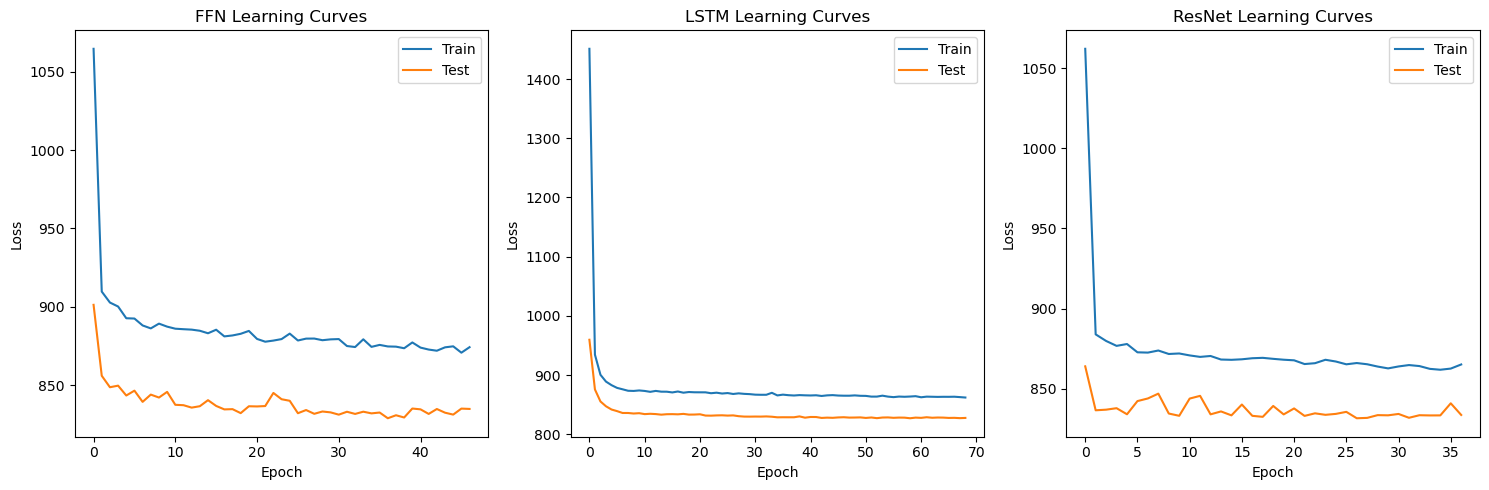

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import platform

# Check if running on M1 Mac and set device
is_m1_mac = platform.processor() == 'arm'
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

class FantasyPointsDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
        
    def __len__(self):
        return len(self.features)
        
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class FFNModel(nn.Module):
    def __init__(self, input_size):
        super(FFNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.model(x)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

class ResNet(nn.Module):
    def __init__(self, input_size):
        super(ResNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.res_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(128, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.BatchNorm1d(128)
            ) for _ in range(3)
        ])
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        for block in self.res_blocks:
            residual = x
            x = block(x)
            x += residual
            x = F.relu(x)
        return self.fc2(x)

def prepare_data(matches_df, ball_by_ball_df):
    """Prepare data with optimized preprocessing"""
    training_data = create_training_data(matches_df, ball_by_ball_df)
    
    feature_cols = [col for col in training_data.columns 
                   if col.startswith(('Batting_', 'Bowling_'))]
    
    X = training_data[feature_cols].values.astype(np.float32)
    y = training_data['total_points'].values.astype(np.float32)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, feature_cols

def train_model(model, X_train, y_train, X_test, y_test, 
                batch_size=32, epochs=100, learning_rate=0.001):
    """Training function with proper tensor handling"""
    train_dataset = FantasyPointsDataset(X_train, y_train)
    test_dataset = FantasyPointsDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_features, batch_targets in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Evaluation
        model.eval()
        test_loss = 0
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for batch_features, batch_targets in test_loader:
                outputs = model(batch_features)
                test_loss += criterion(outputs, batch_targets.unsqueeze(1)).item()
                
                # Convert to Python lists instead of using numpy directly
                all_predictions.extend(outputs.squeeze().tolist())
                all_targets.extend(batch_targets.tolist())
        
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    # Convert final predictions to numpy arrays after collecting all data
    predictions = np.array(all_predictions)
    actuals = np.array(all_targets)
    
    return model, train_losses, test_losses, predictions, actuals

def compare_models(matches_df, ball_by_ball_df):
    """Compare different model architectures"""
    X, y, feature_cols = prepare_data(matches_df, ball_by_ball_df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {
        'FFN': FFNModel(len(feature_cols)),
        'LSTM': LSTMModel(len(feature_cols)),
        'ResNet': ResNet(len(feature_cols))
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name} model...")
        model, train_losses, test_losses, predictions, actuals = train_model(
            model, X_train, y_train, X_test, y_test
        )
        
        # Calculate metrics
        mse = mean_squared_error(actuals, predictions)
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)
        
        results[name] = {
            'mse': mse,
            'mae': mae,
            'r2': r2,
            'train_losses': train_losses,
            'test_losses': test_losses
        }
        
        print(f"{name} Results:")
        print(f"MSE: {mse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"R2: {r2:.2f}")
    
    return results

# Example usage
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    results = compare_models(matches_df, ball_by_ball_df)
    
    # Plot training curves
    plt.figure(figsize=(15, 5))
    for idx, (name, result) in enumerate(results.items(), 1):
        plt.subplot(1, 3, idx)
        plt.plot(result['train_losses'], label='Train')
        plt.plot(result['test_losses'], label='Test')
        plt.title(f'{name} Learning Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

class CricketDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class DualPathAttention(nn.Module):
    def __init__(self, batting_size, bowling_size, hidden_dim):
        super().__init__()
        self.batting_attn = nn.MultiheadAttention(hidden_dim, 4, batch_first=True)
        self.bowling_attn = nn.MultiheadAttention(hidden_dim, 4, batch_first=True)
        
        self.batting_proj = nn.Linear(batting_size, hidden_dim)
        self.bowling_proj = nn.Linear(bowling_size, hidden_dim)
        
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

    def forward(self, batting_features, bowling_features):
        batting = self.batting_proj(batting_features).unsqueeze(1)
        bowling = self.bowling_proj(bowling_features).unsqueeze(1)
        
        batting_attn, _ = self.batting_attn(batting, batting, batting)
        bowling_attn, _ = self.bowling_attn(bowling, bowling, bowling)
        
        batting_out = self.norm1(batting + batting_attn)
        bowling_out = self.norm2(bowling + bowling_attn)
        
        return batting_out.squeeze(1), bowling_out.squeeze(1)

class CricketTransformerV3(nn.Module):
    def __init__(self, batting_size=5, bowling_size=4, hidden_dim=64):
        super().__init__()
        
        self.dual_attn = DualPathAttention(batting_size, bowling_size, hidden_dim)
        
        self.interaction = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.point_predictors = nn.ModuleDict({
            'batting': nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Linear(hidden_dim // 2, 1)
            ),
            'bowling': nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Linear(hidden_dim // 2, 1)
            ),
            'fielding': nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Linear(hidden_dim // 2, 1)
            )
        })
        
        self.final_layer = nn.Linear(3, 1)
        
    def forward(self, x):
        batting_features = x[:, :5]
        bowling_features = x[:, 5:]
        
        batting_encoded, bowling_encoded = self.dual_attn(batting_features, bowling_features)
        combined = torch.cat([batting_encoded, bowling_encoded], dim=1)
        features = self.interaction(combined)
        
        points = {
            key: predictor(features) 
            for key, predictor in self.point_predictors.items()
        }
        
        all_points = torch.cat([points[k] for k in ['batting', 'bowling', 'fielding']], dim=1)
        return self.final_layer(all_points).squeeze()

def train_cricket_transformer(train_data, val_data, num_epochs=100, batch_size=32, 
                            learning_rate=0.001, patience=10):
    feature_cols = ['Batting_Balls_Faced', 'Batting_Average', 'Batting_Strike_Rate',
                   'Batting_Boundary_Rate', 'Batting_Dot_Ball_Percentage',
                   'Bowling_Balls_Bowled', 'Bowling_Economy', 'Bowling_Wickets_per_Ball',
                   'Bowling_Average']
    
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_data[feature_cols])
    val_features = scaler.transform(val_data[feature_cols])
    
    train_dataset = CricketDataset(train_features, train_data['total_points'].values)
    val_dataset = CricketDataset(val_features, val_data['total_points'].values)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = CricketTransformerV3().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss_sum = 0.0
        train_batches = 0
        
        for batch_features, batch_targets in train_loader:
            batch_features = batch_features.to(device)
            batch_targets = batch_targets.to(device)
            
            optimizer.zero_grad()
            predictions = model(batch_features)
            
            mse_loss = F.mse_loss(predictions, batch_targets)
            huber_loss = F.huber_loss(predictions, batch_targets)
            loss = 0.7 * mse_loss + 0.3 * huber_loss
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss_sum += loss.item()
            train_batches += 1
        
        # Validation phase
        model.eval()
        val_loss_sum = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch_features, batch_targets in val_loader:
                batch_features = batch_features.to(device)
                batch_targets = batch_targets.to(device)
                predictions = model(batch_features)
                val_loss = F.mse_loss(predictions, batch_targets)
                
                val_loss_sum += val_loss.item()
                val_batches += 1
        
        avg_train_loss = train_loss_sum / train_batches
        avg_val_loss = val_loss_sum / val_batches
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"Train Loss: {avg_train_loss:.4f}")
            print(f"Val Loss: {avg_val_loss:.4f}")
        
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_cricket_transformer.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(torch.load('best_cricket_transformer.pth'))
    return model, scaler

def evaluate_model(model, test_data, scaler, feature_cols):
    model.eval()
    device = next(model.parameters()).device
    
    test_features = scaler.transform(test_data[feature_cols])
    test_dataset = CricketDataset(test_features, test_data['total_points'].values)
    test_loader = DataLoader(test_dataset, batch_size=64)
    
    total_mse = 0.0
    total_mae = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for batch_features, batch_targets in test_loader:
            batch_features = batch_features.to(device)
            batch_targets = batch_targets.to(device)
            batch_predictions = model(batch_features)
            
            mse = F.mse_loss(batch_predictions, batch_targets, reduction='sum')
            mae = F.l1_loss(batch_predictions, batch_targets, reduction='sum')
            
            total_mse += mse.item()
            total_mae += mae.item()
            total_samples += batch_targets.size(0)
    
    mse = total_mse / total_samples
    mae = total_mae / total_samples
    
    return {
        'MSE': mse,
        'MAE': mae,
        'samples': total_samples
    }

In [14]:
# Split your data
from sklearn.model_selection import train_test_split

# First split into train and temp
train_data, temp_data = train_test_split(training_data, test_size=0.3, random_state=42)
# Split temp into val and test
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Train model
model, scaler = train_cricket_transformer(
    train_data, 
    val_data, 
    num_epochs=100,
    batch_size=32,
    learning_rate=0.001
)

# Evaluate
feature_cols = ['Batting_Balls_Faced', 'Batting_Average', 'Batting_Strike_Rate',
                'Batting_Boundary_Rate', 'Batting_Dot_Ball_Percentage',
                'Bowling_Balls_Bowled', 'Bowling_Economy', 'Bowling_Wickets_per_Ball',
                'Bowling_Average']

results = evaluate_model(model, test_data, scaler, feature_cols)
print(f"\nTest Results:")
print(f"MSE: {results['MSE']:.2f}")
print(f"MAE: {results['MAE']:.2f}")
print(f"Number of samples: {results['samples']}")

Using device: mps
Epoch [10/100]
Train Loss: 632.9887
Val Loss: 891.2127
Epoch [20/100]
Train Loss: 624.6342
Val Loss: 882.2284
Epoch [30/100]
Train Loss: 623.9891
Val Loss: 878.3142
Early stopping at epoch 33

Test Results:
MSE: 805.08
MAE: 22.39
Number of samples: 2938


Training Data Analysis

Sequence Analysis:
Total players: 604

Analyzing sequences for player: A Ashish Reddy
Total matches: 28

First sequence:
Input:
[[ 0  0  0]
 [ 0 50  0]
 [12 29  0]
 [ 0 25  0]
 [ 3 25  0]]
Target:
[ 0 25  0]

Second sequence:
Input:
[[ 0 50  0]
 [12 29  0]
 [ 0 25  0]
 [ 3 25  0]
 [ 0 25  0]]
Target:
[ 9 50  0]

Sequence Statistics:
Number of possible sequences: 23

Average points per type:
batting_points: 11.64 ± 11.16
bowling_points: 16.29 ± 19.45
fielding_points: 2.29 ± 4.20

Value ranges per point type:
batting_points: 0.00 to 44.00
bowling_points: 0.00 to 77.00
fielding_points: 0.00 to 16.00

Overall Dataset Statistics:
Total possible sequences across all players: 9280
Players with enough matches for sequences: 378
Average sequences per player: 24.55

Validation Data Analysis

Sequence Analysis:
Total players: 424

Analyzing sequences for player: AC Gilchrist
Total matches: 5

Not enough matches (5) to create a sequence of length 5

Overall Dataset Statisti

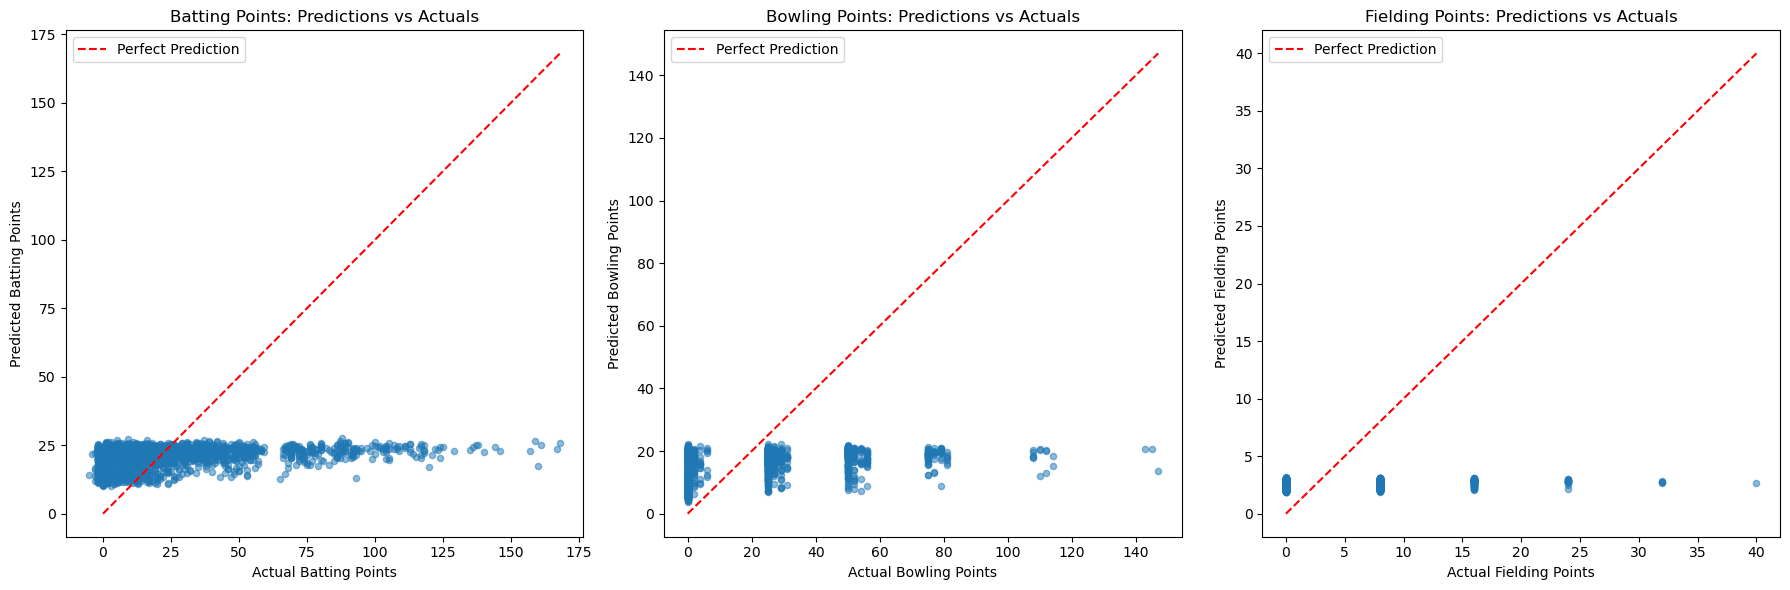

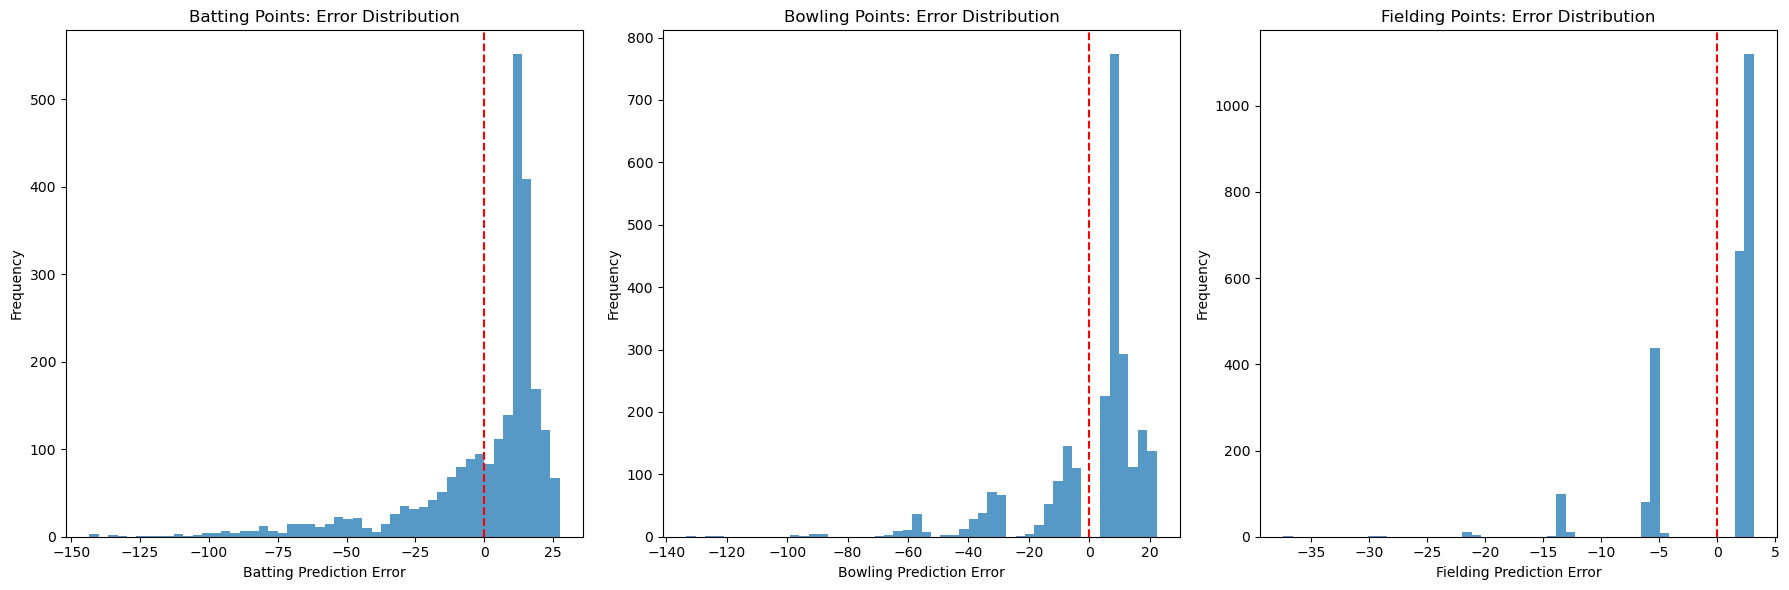


Final Performance Summary:
--------------------------------------------------

Overall Metrics:
MSE: 353.169
RMSE: 18.793
MAE: 12.169

Per-Point Type Performance:

BATTING:
MSE: 663.844
RMSE: 25.765
R² Score: 0.130
Correlation: 0.472

BOWLING:
MSE: 371.799
RMSE: 19.282
R² Score: 0.194
Correlation: 0.528

FIELDING:
MSE: 23.862
RMSE: 4.885
R² Score: 0.021
Correlation: 0.200


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# First split the data
train_data = training_data[training_data['match_id'].isin(train_matches)]
val_data = training_data[training_data['match_id'].isin(val_matches)]
test_data = training_data[training_data['match_id'].isin(test_matches)]

# Fit scaler only on training data
scaler = StandardScaler()
scaler.fit(train_data[['batting_points', 'bowling_points', 'fielding_points']])

class SequenceDataset(Dataset):
    def __init__(self, data, scaler, sequence_length=5):
        self.sequences = []
        self.targets = []
        
        points_columns = ['batting_points', 'bowling_points', 'fielding_points']
        
        # Group by player
        for _, player_data in data.groupby('player'):
            player_data = player_data.sort_values('match_id')
            points = player_data[points_columns].values
            
            # Only create sequences if we have enough matches
            if len(points) >= sequence_length + 1:
                for i in range(len(points) - sequence_length):
                    self.sequences.append(points[i:i+sequence_length])
                    self.targets.append(points[i+sequence_length])
        
        # Transform using provided scaler
        self.sequences = np.array(self.sequences)
        self.targets = np.array(self.targets)
        
        scaled_sequences = scaler.transform(self.sequences.reshape(-1, len(points_columns)))
        self.sequences = scaled_sequences.reshape(self.sequences.shape)
        self.targets = scaler.transform(self.targets)
        
        self.sequences = torch.FloatTensor(self.sequences)
        self.targets = torch.FloatTensor(self.targets)

    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

class PointsPredictor(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_layers=2, dropout=0.2):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        self.attention = nn.MultiheadAttention(hidden_size, 4, batch_first=True)
        
        self.point_processors = nn.ModuleDict({
            'batting': nn.Sequential(
                nn.Linear(hidden_size, hidden_size // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_size // 2, 1)
            ),
            'bowling': nn.Sequential(
                nn.Linear(hidden_size, hidden_size // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_size // 2, 1)
            ),
            'fielding': nn.Sequential(
                nn.Linear(hidden_size, hidden_size // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_size // 2, 1)
            )
        })
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        final_hidden = attn_out[:, -1]
        
        predictions = []
        for processor in self.point_processors.values():
            point_pred = processor(final_hidden)
            predictions.append(point_pred)
        
        return torch.cat(predictions, dim=1)

def analyze_sequences(data, sequence_length=5):
    points_columns = ['batting_points', 'bowling_points', 'fielding_points']
    
    print("\nSequence Analysis:")
    print(f"Total players: {data['player'].nunique()}")
    
    sample_player = data['player'].iloc[0]
    player_data = data[data['player'] == sample_player]
    print(f"\nAnalyzing sequences for player: {sample_player}")
    print(f"Total matches: {len(player_data)}")
    
    if len(player_data) >= sequence_length + 1:
        points = player_data[points_columns].values
        print("\nFirst sequence:")
        print("Input:")
        print(points[0:sequence_length])
        print("Target:")
        print(points[sequence_length])
        
        print("\nSecond sequence:")
        print("Input:")
        print(points[1:sequence_length+1])
        print("Target:")
        if len(points) > sequence_length + 1:
            print(points[sequence_length+1])
        else:
            print("No target available for second sequence")
        
        print("\nSequence Statistics:")
        print(f"Number of possible sequences: {len(points) - sequence_length}")
        
        avg_points = points.mean(axis=0)
        std_points = points.std(axis=0)
        print("\nAverage points per type:")
        for col, avg, std in zip(points_columns, avg_points, std_points):
            print(f"{col}: {avg:.2f} ± {std:.2f}")
        
        print("\nValue ranges per point type:")
        for i, col in enumerate(points_columns):
            min_val = points[:, i].min()
            max_val = points[:, i].max()
            print(f"{col}: {min_val:.2f} to {max_val:.2f}")
    else:
        print(f"\nNot enough matches ({len(player_data)}) to create a sequence of length {sequence_length}")
        
    print("\nOverall Dataset Statistics:")
    total_sequences = sum(len(group) - sequence_length 
                         for _, group in data.groupby('player') 
                         if len(group) > sequence_length)
    print(f"Total possible sequences across all players: {total_sequences}")
    
    players_with_sequences = sum(len(group) > sequence_length 
                               for _, group in data.groupby('player'))
    print(f"Players with enough matches for sequences: {players_with_sequences}")
    
    avg_sequences_per_player = total_sequences / players_with_sequences if players_with_sequences > 0 else 0
    print(f"Average sequences per player: {avg_sequences_per_player:.2f}")

def train_predictor(train_data, val_data, sequence_length=5, num_epochs=100, batch_size=32):
    scaler = StandardScaler()
    points_columns = ['batting_points', 'bowling_points', 'fielding_points']
    train_points = train_data[points_columns].values
    scaler.fit(train_points)
    
    train_dataset = SequenceDataset(train_data, scaler, sequence_length)
    val_dataset = SequenceDataset(val_data, scaler, sequence_length)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = PointsPredictor().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.01,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader)
    )
    
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss_sum = 0
        
        for sequences, targets in train_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            predictions = model(sequences)
            loss = F.mse_loss(predictions, targets)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            
            train_loss_sum += loss.item()
        
        model.eval()
        val_loss_sum = 0
        
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences = sequences.to(device)
                targets = targets.to(device)
                
                predictions = model(sequences)
                val_loss = F.mse_loss(predictions, targets)
                val_loss_sum += val_loss.item()
        
        avg_train_loss = train_loss_sum / len(train_loader)
        avg_val_loss = val_loss_sum / len(val_loader)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"Train Loss: {avg_train_loss:.4f}")
            print(f"Val Loss: {avg_val_loss:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_points_predictor.pth')
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(torch.load('best_points_predictor.pth'))
    return model, scaler

def evaluate_predictor(model, test_data, scaler, sequence_length=5):
    model.eval()
    device = next(model.parameters()).device
    
    test_dataset = SequenceDataset(test_data, scaler, sequence_length)
    test_loader = DataLoader(test_dataset, batch_size=64)
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            predictions = model(sequences)
            
            if device.type == 'mps':
                predictions_list = predictions.to('cpu').tolist()
                targets_list = targets.to('cpu').tolist()
                predictions_np = np.array(predictions_list)
                targets_np = np.array(targets_list)
            else:
                predictions_np = predictions.detach().numpy()
                targets_np = targets.detach().numpy()
            
            predictions_np = scaler.inverse_transform(predictions_np)
            targets_np = scaler.inverse_transform(targets_np)
            
            all_predictions.extend(predictions_np)
            all_targets.extend(targets_np)
    
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    print("\nDetailed Performance Metrics:")
    print("-" * 50)
    
    overall_mse = np.mean((all_predictions - all_targets) ** 2)
    overall_rmse = np.sqrt(overall_mse)
    overall_mae = np.mean(np.abs(all_predictions - all_targets))
    
    print(f"\nOverall Metrics:")
    print(f"MSE: {overall_mse:.3f}")
    print(f"RMSE: {overall_rmse:.3f}")
    print(f"MAE: {overall_mae:.3f}")
    
    detailed_metrics = {}
    for i, point_type in enumerate(['batting', 'bowling', 'fielding']):
        predictions = all_predictions[:, i]
        actuals = all_targets[:, i]
        
        mse = np.mean((predictions - actuals) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(predictions - actuals))
        r2 = 1 - (np.sum((actuals - predictions) ** 2) / np.sum((actuals - np.mean(actuals)) ** 2))
        correlation = np.corrcoef(predictions, actuals)[0,1]
        
        error = np.abs(predictions - actuals)
        within_5 = np.mean(error <= 5) * 100
        within_10 = np.mean(error <= 10) * 100
        within_20 = np.mean(error <= 20) * 100
        
        detailed_metrics[point_type] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'Correlation': correlation,
            'Within_5_points': within_5,
            'Within_10_points': within_10,
            'Within_20_points': within_20
        }
        
        print(f"\n{point_type.upper()} METRICS:")
        print(f"MSE: {mse:.3f}")
        print(f"RMSE: {rmse:.3f}")
        print(f"MAE: {mae:.3f}")
        print(f"R² Score: {r2:.3f}")
        print(f"Correlation: {correlation:.3f}")
        print(f"Predictions within 5 points: {within_5:.1f}%")
        print(f"Predictions within 10 points: {within_10:.1f}%")
        print(f"Predictions within 20 points: {within_20:.1f}%")
    
    bias = {}
    for i, point_type in enumerate(['batting', 'bowling', 'fielding']):
        mean_pred = np.mean(all_predictions[:, i])
        mean_actual = np.mean(all_targets[:, i])
        bias[point_type] = mean_pred - mean_actual
        print(f"\n{point_type.upper()} Prediction Bias: {bias[point_type]:.3f}")
    
    return {
        'overall': {
            'MSE': overall_mse,
            'RMSE': overall_rmse,
            'MAE': overall_mae
        },
        'detailed_metrics': detailed_metrics,
        'bias': bias,
        'predictions': all_predictions,
        'actuals': all_targets,
        'samples': len(all_predictions)
    }

def plot_performance_metrics(results):
    predictions = results['predictions']
    actuals = results['actuals']
    
    # Create subplots for each point type
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    point_types = ['Batting', 'Bowling', 'Fielding']
    
    for i, (ax, point_type) in enumerate(zip(axes, point_types)):
        ax.scatter(actuals[:, i], predictions[:, i], alpha=0.5, s=20)
        ax.plot([0, max(actuals[:, i])], [0, max(actuals[:, i])], 'r--', label='Perfect Prediction')
        ax.set_xlabel(f'Actual {point_type} Points')
        ax.set_ylabel(f'Predicted {point_type} Points')
        ax.set_title(f'{point_type} Points: Predictions vs Actuals')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot error distribution
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, (ax, point_type) in enumerate(zip(axes, point_types)):
        errors = predictions[:, i] - actuals[:, i]
        ax.hist(errors, bins=50, alpha=0.75)
        ax.axvline(x=0, color='r', linestyle='--')
        ax.set_xlabel(f'{point_type} Prediction Error')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{point_type} Points: Error Distribution')
    
    plt.tight_layout()
    plt.show()

# Run the complete analysis pipeline
if __name__ == "__main__":
    # Analyze the sequences
    print("Training Data Analysis")
    analyze_sequences(train_data)
    print("\nValidation Data Analysis")
    analyze_sequences(val_data)
    print("\nTest Data Analysis")
    analyze_sequences(test_data)
    
    # Train the model
    model, scaler = train_predictor(train_data, val_data, sequence_length=5)
    
    # Evaluate and visualize results
    results = evaluate_predictor(model, test_data, scaler)
    plot_performance_metrics(results)
    
    # Print final summary
    print("\nFinal Performance Summary:")
    print("-" * 50)
    print("\nOverall Metrics:")
    print(f"MSE: {results['overall']['MSE']:.3f}")
    print(f"RMSE: {results['overall']['RMSE']:.3f}")
    print(f"MAE: {results['overall']['MAE']:.3f}")
    
    print("\nPer-Point Type Performance:")
    for point_type, metrics in results['detailed_metrics'].items():
        print(f"\n{point_type.upper()}:")
        print(f"MSE: {metrics['MSE']:.3f}")
        print(f"RMSE: {metrics['RMSE']:.3f}")
        print(f"R² Score: {metrics['R2']:.3f}")
        print(f"Correlation: {metrics['Correlation']:.3f}")